# chapter 3. 추정과 가설검정

---

## Part 0.미리보는 추정과 가설검정

### 핵심 정리 요약

| 개념                | 한 줄 요약                                                    |
|---------------------|---------------------------------------------------------------|
| **표본분포**        | 표본평균이 따르는 분포, n이 클수록 좁아진다                   |
| **중심극한정리**    | n ≥ 30이면 모집단 분포와 관계없이 표본평균은 정규분포에 수렴  |
| **신뢰구간**        | 모수를 포함할 것으로 기대하는 구간 (95%: 100번 중 95번 포함)  |
| **가설검정**        | H₀를 가정 → 데이터로 증거 평가 → p-value로 판정              |
| **p-value**         | H₀ 하에서 이 결과가 얼마나 드문지를 나타내는 확률             |
| **1종/2종 오류**    | 1종: 없는데 있다고 (α) / 2종: 있는데 없다고 (β)              |
| **검정력**          | 진짜 효과를 탐지할 능력 (1-β), 최소 80% 권장                 |
| **효과크기**        | 차이의 실질적 크기 (p-value와 별개로 항상 보고해야 함)        |

### 실전 가설검정 프로세스 체크리스트

| 단계 | 체크 항목                    | 주의 사항                                          |
|------|------------------------------|----------------------------------------------------|
| 1    | 연구 질문 명확화             | 무엇을 알고 싶은지 구체적으로 정의                 |
| 2    | 가설 설정 (H₀, H₁)         | 연구 질문에 맞는 적절한 가설 설정                   |
| 3    | 유의수준 α 설정             | 데이터를 보기 **전에** 결정 (보통 0.05)             |
| 4    | 적절한 검정 방법 선택        | 데이터 유형, 표본 수, 가정 확인                     |
| 5    | 가정 확인                    | 정규성, 등분산성, 독립성 등                         |
| 6    | 검정 실행                    | 검정통계량, p-value 계산                            |
| 7    | 결론 도출                    | p ≤ α → 기각, p > α → 기각 실패                   |
| 8    | 효과크기 보고                | 통계적 유의성 + 실질적 의미 함께 판단               |
| 9    | 신뢰구간 제시                | 점추정값과 함께 구간추정 결과 보고                  |
| 10   | 한계점 인식                  | 표본크기, 가정 위반, 다중검정 문제 등 고려          |

### 1. 기본 통계량 계산

```python
import numpy as np
from scipy import stats

sample = np.array([...])

np.mean(sample)              # 표본평균 x̄
np.std(sample, ddof=1)       # 표본표준편차 s (ddof=1: 불편추정량, n-1로 나눔)
np.var(sample, ddof=1)       # 표본분산 s²
stats.sem(sample)            # 표준오차 SE = s / √n (stats.sem이 자동 계산)
```

> **ddof 주의**: `numpy`는 `ddof=0`이 기본(모표준편차), `pandas`는 `ddof=1`이 기본(표본표준편차)
> 표본 통계량을 구할 때는 반드시 `ddof=1`을 명시

### 2. 신뢰구간 계산

```python
from scipy import stats

n = len(sample)
xbar = np.mean(sample)
se = stats.sem(sample)  # 표준오차

# ── 양측 신뢰구간 (가장 많이 사용) ──
ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=xbar, scale=se)
# → "95% 신뢰수준으로 모평균이 [ci_low, ci_high] 사이에 있다"

# ── 수동 계산 ──
t_crit = stats.t.ppf(1 - 0.05/2, df=n-1)  # 양측 임계값
margin = t_crit * se                        # 오차한계
ci_low, ci_high = xbar - margin, xbar + margin

# ── 하한 단측 CI: "최소 얼마 이상인가?" ──
t_one = stats.t.ppf(0.95, df=n-1)           # 단측 임계값
lower_bound = xbar - t_one * se
# → (lower_bound, +∞)

# ── 상한 단측 CI: "최대 얼마 이하인가?" ──
upper_bound = xbar + t_one * se
# → (-∞, upper_bound)
```


### 3. 표본크기 결정

```python
# "오차한계 E 이내로 추정하려면 표본이 몇 개 필요한가?"
sigma_est = 2.0    # 추정 표준편차
z = 1.96           # 95% 신뢰수준
E = 0.5            # 원하는 오차한계

n_required = np.ceil((z * sigma_est / E) ** 2)
```

### 4. 가설검정 (scipy.stats)

| 검정 방법 | 함수 | 사용 상황 |
|-----------|------|-----------|
| **단일표본 t-검정** | `stats.ttest_1samp(data, popmean=μ₀)` | 표본평균이 특정 값과 다른가? |
| **독립표본 t-검정** | `stats.ttest_ind(a, b, equal_var=False)` | 두 그룹의 평균이 다른가? (Welch's) |
| **대응표본 t-검정** | `stats.ttest_rel(before, after)` | 같은 대상의 전후 차이가 있는가? |
| **등분산 검정 (Levene)** | `stats.levene(a, b)` | 두 그룹의 분산이 같은가? |
| **등분산 검정 (Bartlett)** | `stats.bartlett(a, b)` | 두 그룹의 분산이 같은가? (정규성 가정) |

#### `alternative` 파라미터 (단측/양측 검정)

> scipy.stats의 t-검정 함수들은 `alternative` 파라미터를 지원합니다.
> 이전에는 양측 p-value만 반환했기 때문에 수동으로 단측 변환이 필요했지만,
> **현재는 `alternative`를 지정하면 단측 p-value를 직접 올바르게 얻을 수 있습니다.**

| 파라미터 값 | 의미 | 사용 상황 |
|-------------|------|-----------|
| `'two-sided'` (기본값) | 양측검정 | H₁: μ ≠ μ₀ |
| `'greater'` | 우측검정 | H₁: μ > μ₀ |
| `'less'` | 좌측검정 | H₁: μ < μ₀ |

```python
# ── 양측검정 (기본값) ──
t_stat, p_value = stats.ttest_1samp(data, popmean=130)

# ── 단측검정: alternative 파라미터 사용 (권장) ──
t_stat, p_value = stats.ttest_1samp(data, popmean=130, alternative='greater')  # 우측
t_stat, p_value = stats.ttest_1samp(data, popmean=130, alternative='less')     # 좌측

# ── 독립표본 t-검정 (Welch's) + 단측 ──
t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=False, alternative='greater')

# ── 대응표본 t-검정 + 단측 ──
t_stat, p_value = stats.ttest_rel(after, before, alternative='greater')
```

### 5. 단측검정 p-value 수동 변환 (참고)

> `alternative` 파라미터가 없던 이전 버전에서 사용하던 방법입니다.
> 현재는 위의 `alternative` 파라미터를 사용하는 것이 권장됩니다.

```python
t_stat, p_two = stats.ttest_1samp(data, popmean=mu_0)  # 양측 p-value

# 좌측검정 (H1: μ < μ₀)
p_left = p_two / 2 if t_stat < 0 else 1 - p_two / 2

# 우측검정 (H1: μ > μ₀)
p_right = p_two / 2 if t_stat > 0 else 1 - p_two / 2
```

### 6. z-검정 (수동 구현, 모분산 σ를 아는 경우)

```python
z_stat = (xbar - mu_0) / (sigma / np.sqrt(n))  # z 검정통계량

p_right = stats.norm.sf(z_stat)      # 우측 p-value: P(Z > z)
p_left  = stats.norm.cdf(z_stat)     # 좌측 p-value: P(Z < z)
p_two   = 2 * stats.norm.sf(abs(z_stat))  # 양측 p-value
```

### 7. 효과크기 (Cohen's d)

```python
# 단일표본:  d = |x̄ - μ₀| / s
d = abs(np.mean(data) - mu_0) / np.std(data, ddof=1)

# 독립표본:  d = |x̄₁ - x̄₂| / s_pooled
n1, n2 = len(g1), len(g2)
s_pooled = np.sqrt(((n1-1)*np.var(g1, ddof=1) + (n2-1)*np.var(g2, ddof=1)) / (n1+n2-2))
d = abs(np.mean(g1) - np.mean(g2)) / s_pooled

# 대응표본:  d = |x̄_diff| / s_diff
diff = after - before
d = abs(np.mean(diff)) / np.std(diff, ddof=1)
```

| Cohen's d | 해석 |
|-----------|------|
| < 0.2 | 무시할 수준 |
| 0.2 ~ 0.5 | 작은 효과 |
| 0.5 ~ 0.8 | 중간 효과 |
| ≥ 0.8 | 큰 효과 |

### 8. 검정력 분석 (statsmodels)

```python
from statsmodels.stats.power import TTestPower

analysis = TTestPower()
d = abs(mu_1 - mu_0) / sigma  # Cohen's d

# 필요 표본크기 역산 (가장 많이 사용)
n = analysis.solve_power(effect_size=d, alpha=0.05, power=0.80, alternative='smaller')

# 검정력 계산
power = analysis.solve_power(effect_size=d, nobs=50, alpha=0.05, alternative='smaller')

# 탐지 가능한 최소 효과크기
min_d = analysis.solve_power(nobs=50, alpha=0.05, power=0.80, alternative='smaller')
```

> **solve_power**: 4개 인자(effect_size, nobs, alpha, power) 중 **1개를 None**으로 두면 나머지 3개로 역산! \
> **solve_power 주의사항** : `alternative`와 `effect_size` 부호 \
> statsmodels의 `alternative`는 scipy.stats와 **값이 다릅니다** (`'greater'`/`'less'`가 아닌 `'larger'`/`'smaller'`).
> 또한 **effect_size(d)의 부호 기준**으로 방향을 잡습니다.
> - `d = +0.333` + `alternative='larger'` → 검정력 계산 O
> - `d = -0.333` + `alternative='smaller'` → 같은 결과
> - 방향만 맞으면 결과가 동일하므로, 관례적으로 **d를 양수(abs)로 넣고 `'larger'`를 사용**합니다.
> | scipy.stats | statsmodels (solve_power) | 의미 |
> |-------------|--------------------------|------|
> | `'two-sided'` | `'two-sided'` | 양측검정 |
> | `'greater'` | `'larger'` | 우측 (효과 양의 방향) |
> | `'less'` | `'smaller'` | 좌측 (효과 음의 방향) |

### 9. 검정 방법 선택 가이드

```plain
모분산(σ)을 아는가?
├─ Yes → z-검정 (실무에서 거의 없음)
│   └─ 효과크기: Cohen's d = |x̄ - μ₀| / σ
└─ No
   ├─ 그룹이 1개 → 단일표본 t-검정 (stats.ttest_1samp)
   │   └─ 효과크기: Cohen's d = |x̄ - μ₀| / s
   └─ 그룹이 2개
      ├─ 같은 대상의 전후 비교 → 대응표본 t-검정 (stats.ttest_rel)
      │   └─ 효과크기: Cohen's d = |x̄_diff| / s_diff
      └─ 서로 다른 대상 비교 → 독립표본 t-검정 (stats.ttest_ind, equal_var=False)
          └─ 효과크기: Cohen's d = |x̄₁ - x̄₂| / s_pooled
```

---

## 목차

| 순서 | 파트   | 주제                | 핵심 내용                                            |
|------|--------|---------------------|------------------------------------------------------|
| 1    | Part 1 | 핵심 정리           | 추정 vs 가설검정, 핵심 수식, 용어 정리               |
| 2    | Part 2 | 표본분포와 중심극한정리 | 표본추출, 표본평균의 분포, CLT, 표준오차             |
| 3    | Part 3 | 통계적 추정         | 점추정, 구간추정, 신뢰구간, 표본크기 결정            |
| 4    | Part 4 | 가설검정 기초       | 귀무/대립가설, p-value, 유의수준, 판정 규칙          |
| 5    | Part 5 | 주요 검정 방법      | z-검정, 단일표본/독립표본/대응표본 t-검정            |
| 6    | Part 6 | 오류와 검정력       | 1종/2종 오류, 검정력, 효과크기, 표본크기 설계        |
| 7    | Part 7 | 과제           | A/B 테스트, 품질 관리, 실전 가설검정 프로세스        |

---

## Part 1: 추정 vs 가설검정 핵심 정리


추정 (Estimation)\
모수가 얼마일까? 를 표본으로 값(점)이나 범위(신뢰구간)로 말한다.\
점추정(한 값) / 구간추정(신뢰구간)

가설검정 (Hypothesis Testing)\
주장이 맞을까?를 표본으로 증거(p-value) 강도를 보고 판단한다. (귀무가설과 대립가설)\
H0 기각 or 기각 실패 (p-value를 유의수준 α와 비교)

공통점\
둘 다 표본에서 출발해서 모집단에 대한 결론을 내리는 통계적 추론이다.



<img src="images/pr_03/추정_vs_가설검정.png" width="50%">

> **핵심**: 추정은 "모수가 얼마인지 범위를 좁히는 것", 가설검정은 "주장에 대해 증거를 평가하는 것"

### 잠깐 짚고 넘어가기: 주요 용어 정리

| 용어 | 영어 | 정의 | 예시 |
|------|------|------|------|
| 모수 | Parameter | 모집단의 특성값 — 고정된 값이지만 알 수 없음 | 전국 성인 평균 키 μ = 170cm |
| 모분포 | Population Distribution | 모집단 데이터가 따르는 확률분포 | 성인 키 ~ 정규분포 N(170, 6²) |
| 표본 | Sample | 모집단에서 뽑은 데이터 여러 개의 묶음 | 무작위로 뽑은 100명의 키 데이터 |
| 통계량 | Statistic | 표본에서 계산한 값 — 표본마다 달라짐 | 100명의 평균 x̄ = 171.3cm |
| 추정량 | Estimator | 모수를 추정하는 데 사용하는 공식 | $\bar{X} = \frac{1}{n}\sum X_i$ |
| 추정값 | Estimate | 추정량에 실제 데이터를 넣어 얻은 구체적인 값 | x̄ = 171.3cm |
| 표본분포 | Sampling Distribution | 통계량(예: 표본평균)이 따르는 확률분포 | 100명씩 반복 추출한 평균들의 분포 |
| 표준오차 | Standard Error (SE) | 통계량의 표준편차 — 추정의 정밀도를 나타냄 | SE = 6/√100 = 0.6cm |
| 신뢰구간 | Confidence Interval (CI) | 모수가 포함될 것으로 기대하는 구간 | 95% CI: [170.1, 172.5]cm |
| 귀무가설 | Null Hypothesis (H₀) | "차이가 없다 / 효과가 없다"는 기본 주장 — 기각 대상입니다 | H₀: μ = 170 (평균 키는 170cm과 다르지 않다) |
| 대립가설 | Alternative Hyp. (H₁) | "차이가 있다 / 효과가 있다"는 연구자의 주장 — 입증 대상입니다 | H₁: μ ≠ 170 (평균 키는 170cm과 다르다) |
| p-value | p-value | 귀무가설이 맞다면 이런 결과가 우연히 나올 확률 | p = 0.03 → 유의 수준(α) 보다 작으므로 H₀ 기각 |
| 유의수준 | Significance Level (α) | 판단 기준선 — p-value가 이보다 작으면 H₀를 기각합니다 | α = 0.05 (5%) |

In [20]:
# 필수 라이브러리 Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import platform

warnings.filterwarnings('ignore')

# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 전역 시드 설정 (재현성을 위해)
np.random.seed(42)

print("=" * 60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("=" * 60)

라이브러리 로드 완료!
한글 폰트 설정 완료!


---

## Part 2: 표본분포와 중심극한정리

### 1. 모집단과 표본
모집단 (Population): 관심있는 대상의 전체 집합\
보통 우리가 알고 싶은 대상으로, 크기 $N$이 매우 크거나 무한대에 가깝다.\
이 때문에 모집단의 평균μ, 표준편차σ 같은 값(모수)은 고정됬으나 전수조사가 어려워 직접 알기 어렵다.

표본 (Sample): 모집단에서 추출한 일부의 집합\
모집단을 대표하는 일부의 집단. 크기 $n$은 유한하다.\
표본에서 계산한 평균 x̄, 표준편차 s 같은 값(통계량)은 표본을 어떻게 뽑았냐에 따라 계속 변화한다.

예시 설명\
전국 성인 남성의 키 전체: 모집단\
100명을 무작위로 뽑아 측정한 키

> 모수크키 N은 무한대에 가깝다. 때문에 전수조사엔 많은 비용과 시간이 소모된다.\
이 문제를 해결하기 위해 모수를 대표하는 집단인 표본을 사용해 모집단을 추론한다.\
이를 **통계적 추론(Statistical Inference)**이라 부른다.



### 2. 표본분포 (Sampling Distribution)
같은 크기의 표본을 여러 번 뽑아 통계량을 계산하면, 그 통계량들이 만드는 분포가 표본분포다.
> 분포: 어떤 값들이 얼마나 자주 나오는지(확률이나 빈도)를 값의 범위 전체에 걸쳐 정리한 것이다.

개념설명\
모집단에서 표본을 한번 뽑으면 표본 x̄ 값 하나가 나온다.\
이때 표본을 똑같은 방식으로 여러번 추출하면 x̄값이 조금씩 달리 나온다.\
바뀐 통계량 값들의 패턴(분포)를 모은것이 바로 **표본분포**다.

예시설명: 전국 대학생 키의 평균\
대학생 전체의 키로 평균을 내기 어렵기 때문에 표본을 추출한다.\
약 100명의 대학생을 무작위로 추출해 평균을 내 x̄1, 다시 무작위로 뽑아 평균을 내 x̄2\
위 행위를 n번 반복해 나온 표본평균들(x̄1, x̄2, x̄3 ... x̄n), 이를의 분포가 **표본분포**다.

> 예) 표본**평균**의 분포, 표본**비율**의 분포 등이 모두 표본분포다.

#### 대표 예시: 미리보기

| 성질             | 수식                                  | 의미                                          |
|------------------|---------------------------------------|-----------------------------------------------|
| **기대값**       | $E[\bar{X}] = \mu$                   | 표본평균의 평균은 모평균과 같다 (불편성)      |
| **분산**         | $Var(\bar{X}) = \frac{\sigma^2}{n}$  | n이 커질수록 분산 감소 → 더 정밀한 추정       |
| **표준오차(SE)** | $SE = \frac{\sigma}{\sqrt{n}}$       | 표본평균들의 표준편차 (추정의 정밀도)           |

여기서 **n**은 하나의 표본에 포함된 데이터 개수(표본크기)다. 예) 100명을 뽑았으면 n = 100
>**n이 커지면?** 표본평균들의 분산이 줄어들어 모평균 근처에 더 촘촘히 모인다.\
즉, **표본이 클수록 추정이 정밀해진다.**

<img src="images/pr_03/표본분포_개념.png" width="80%">

In [21]:
print("\n[실습] 표본분포 체험")
print("목적 1. 불편성 검증: 표본평균들의 평균 ≈ 모평균 → 표본평균이 모평균을 잘 추정한다")
print("목적 2. SE 공식 검증: 이론적 SE(σ/√n) ≈ 실제 SE → 공식이 실제로 맞다")
print("=" * 50)

# 모집단 생성 (지수분포: 오른쪽 꼬리가 긴 비대칭 분포)
np.random.seed(42)
population = np.random.exponential(scale=5, size=100000)
pop_mean = np.mean(population)
pop_std = np.std(population)

print(f"모집단 크기: {len(population):,}")
print(f"모평균 (μ): {pop_mean:.2f}")
print(f"모표준편차 (σ): {pop_std:.2f}")

# 다양한 표본크기로 표본평균의 분포 확인
print("\n[표본크기별 표본평균의 분포]")
print("-" * 50)

for n in [5, 30, 100]:
    # TODO: n개의 표본 추출하여 표본 평균을 구하는 것을 1000번 반복 (np.random.choice)
    # np.random.choice(population, size=n) : 모집단에서 n개만큼 추출
    # np.mean(np.random.choice(population, size=n)) : 모집단에서 n개만큼 추출해서 평균을 냄
   
    # sample_means = [np.mean(np.random.choice(population, size=n)) for _ in range(1000)] 
    # 위 과정을 1000번 반복해서 표본 평균의 개수 1000개를 생성
    sample_means = []
    for _ in range(1000) :
        sample_means.append(np.mean(np.random.choice(population, size=n)))

    # TODO: 이론적 표준오차 (pop_std / np.sqrt(n))
    se_theory = pop_std / np.sqrt(n) #공식

    # TODO: 실제 표준오차 (np.std(sample_means))
    se_actual = np.std(sample_means)

    se_theory_viz = se_theory if se_theory is not None else 0
    se_actual_viz = se_actual if se_actual is not None else 0
    mean_viz = np.mean(sample_means) if sample_means is not None else 0

    print(f"\nn = {n:>3d}")
    print(f"  표본평균들의 평균: {mean_viz:.2f} (모평균: {pop_mean:.2f})")
    print(f"  이론적 SE = σ/√n = {pop_std:.2f}/√{n} = {se_theory_viz:.3f}")
    print(f"  실제 SE (시뮬레이션):           {se_actual_viz:.3f}")


[실습] 표본분포 체험
목적 1. 불편성 검증: 표본평균들의 평균 ≈ 모평균 → 표본평균이 모평균을 잘 추정한다
목적 2. SE 공식 검증: 이론적 SE(σ/√n) ≈ 실제 SE → 공식이 실제로 맞다
모집단 크기: 100,000
모평균 (μ): 4.98
모표준편차 (σ): 4.96

[표본크기별 표본평균의 분포]
--------------------------------------------------

n =   5
  표본평균들의 평균: 5.01 (모평균: 4.98)
  이론적 SE = σ/√n = 4.96/√5 = 2.220
  실제 SE (시뮬레이션):           2.158

n =  30
  표본평균들의 평균: 5.06 (모평균: 4.98)
  이론적 SE = σ/√n = 4.96/√30 = 0.906
  실제 SE (시뮬레이션):           0.893

n = 100
  표본평균들의 평균: 5.01 (모평균: 4.98)
  이론적 SE = σ/√n = 4.96/√100 = 0.496
  실제 SE (시뮬레이션):           0.486


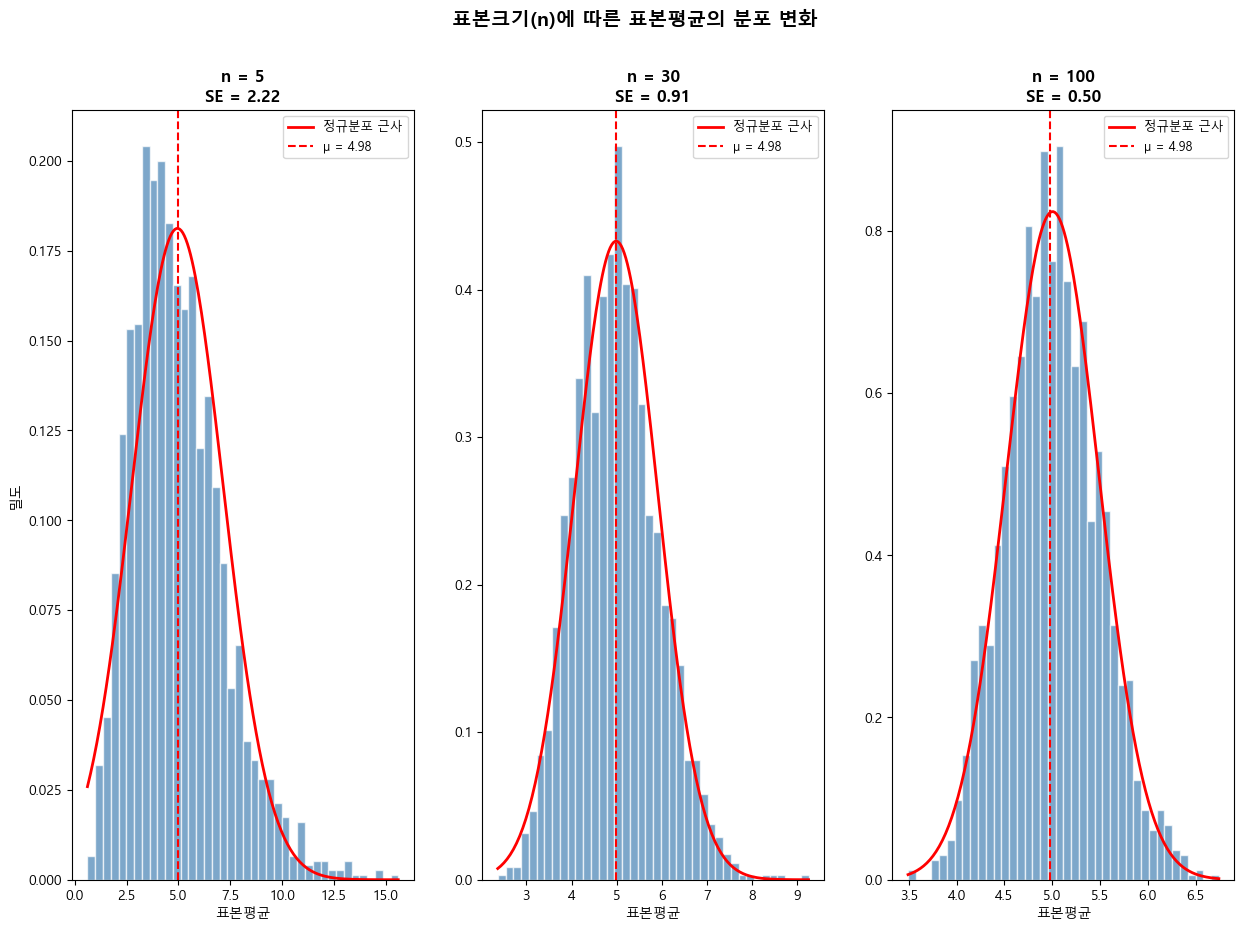

In [22]:
# 시각화: 표본크기별 표본평균의 분포 (CLT 검증)
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
fig.suptitle('표본크기(n)에 따른 표본평균의 분포 변화', fontsize=14, fontweight='bold')

np.random.seed(42)
for i, n in enumerate([5, 30, 100]):
    sample_means = [np.mean(np.random.choice(population, size=n)) for _ in range(2000)]

    axes[i].hist(sample_means, bins=40, density=True, color='steelblue',
                 alpha=0.7, edgecolor='white')

    x = np.linspace(min(sample_means), max(sample_means), 200)
    axes[i].plot(x, stats.norm.pdf(x, np.mean(sample_means), np.std(sample_means)),
                 'r-', linewidth=2, label='정규분포 근사')

    axes[i].axvline(pop_mean, color='red', linestyle='--', linewidth=1.5,
                    label=f'μ = {pop_mean:.2f}')
    axes[i].set_title(f'n = {n}\nSE = {pop_std/np.sqrt(n):.2f}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('표본평균')
    axes[i].legend(fontsize=9)
    if i == 0:
        axes[i].set_ylabel('밀도')

### 3. 중심극한정리 (Central Limit Theorem, CLT)
모집단 분포 모양이 어떻든, n이 커지면 표본평균 x̄의 분포는 정규분포에 가까워진다.

$\bar{X} ≈ N\left(\mu, \frac{\sigma^2}{n}\right) \quad \text{(n이 충분히 클 때)}$


이때 표본평균의 중심은 μ\
분산은 $\frac{\sigma^2}{n}$\
표준오차(SE)는 $\frac{\sigma}{√n}$수준이 된다.

예시설명: \
주사위(1~6)는 정규분포가 아니지만, 30개씩 뽑아 평균을 내는 일을 반복하면 그 평균값들은 종 모양에 가까워진다.

> 보통 실무/수업에서는 "n ≥ 30이면 꽤 근사된다"로 시작한다(상황에 따라 더 필요할 때도 있음).\
물론 모집단이 극단적으로 비대칭이거나 이상치가 많은경우 n ≥ 30으로도 부족할 수 있다.

#### CLT가 중요한 이유
신뢰구간·가설검정은 "표본평균 x̄를 정규로 근사할 수 있다"를 전제로 작동한다.\
즉, 모집단이 정규가 아니어도 평균에 대해 계산이 가능해진다.

특히 Part 3(신뢰구간) 공식이 전부 "점추정 ± (임계값 × SE)" 구조로 나오는 이유가 여기 있다.

#### CLT에 대한 흔한 오해
1. 원래 데이터가 정규가 된다?\
정규에 가까워지는 건 원래 데이터가 아닌 표본평균들의 분포다.\
주사위 값 자체는 계속 1~6이지만, 30개 평균은 종 모양이 된다.

2. 반복을 많이 하면 정규가 된다?\
반복 횟수는 히스토그램을 더 매끈하게 보이게 할 뿐이다.\
정규성에 영향을 주는건 반복 획수가 아닌 표본크기 n이다.

3. n ≥ 30이면 항상 충분하다?\
30은 경험적 시작점이다. 극단적 비대칭, 이상치 많음, 꼬리 매우 김이면 더 큰 n이 필요할 수 있다.

### 4. 표본오차 (Sampling Error) 와 표준오차 (Standard Error, SE)
표본오차는 **표본의 실제 빗나감**, 표준오차는 **그 빗나감이 보통 어느 정도일지의 크기**(평균적 흔들림)다.


표본오차 (Sampling Error)\
표본평균 x̄ 와 모평균 μ의 차이 (x̄−μ)같은 **실제 빗나감**을 말한다.\
다만 현실에선 모평균 μ을 모르기 때문에 표본오차를 정확히 계산하기 어렵다.\
예시: 모평균이 진짜 170인데 표본평균이 171.3이면 표본오차는 1.3이다. (하지만 μ를 모르니 보통은 모른다)

<br>

표준오차 (Standard Error, SE)\
표본평균이 평균적으로 얼마나 흔들릴지를 나타내는 값이다.\
표본을 여러 번 뽑아 평균을 내면 평균값들이 조금씩 다르게 나오는데, 그 평균들의 표준편차가 SE다.\
표준오차:$SE = \frac {σ}{√n}$\
σ를 모르면: $SE≈\frac{s}{√n}$ 


예시: 표준편차 s=10 표본크기 n=100 이면\
$SE≈10 / \sqrt{100} = 1$ 

| 구분     | 표본오차 (Sampling Error) | 표준오차 (Standard Error, SE)                               |
| ------ | --------------------- | ------------------------------------------------------- |
| 정의     | 특정 표본의 통계량과 모수 간의 **실제 차이** | 표본 통계량(주로 표본평균)들의 **표준편차**                          |
| 의미     | 이번 표본이 얼마나 빗나갔나       | 보통 어느 정도 빗나갈까(흔들림 크기)                                   |
| 수식(평균) | $(\bar x - \mu)$        | $SE = \frac {σ}{√n}$ <br> σ를 모르면: $SE≈\frac{s}{√n}$  |
| 계산 가능성 | $\mu$를 몰라 직접 계산 어려움   | 표본으로 추정 가능                                              |
| n이 커지면 | 오차는 줄 수도/늘 수도 있음(운)   | 줄어든다
| 활용     | 직접 쓰기보단 “존재 이유” 정도    | 신뢰구간, 가설검정의 핵심 재료                                       |
| 예시 | 모평균 μ=170, 표본평균 x̄=171.3 → 오차 = 1.3 | 100명씩 반복 추출한 표본평균들의 표준편차 = 0.6 |

---

## Part 3: 통계적 추정

1. 점추정
2. 구간추정과 신뢰구간
3. 신뢰구간의 올바른 해석
4. 신뢰수준 구간 너비의 관계
5. 단축신뢰구간
6. 추정이 목적일때 표본크기 결정


### 1. 점추정 (Point Estimation)
모수(μ, σ², p)를 표본에서 계산한 하나의 값(추정값)으로 추정한다.

| 모수             | 점추정량                      | 성질               |
|------------------|-------------------------------|--------------------|
| 모평균 μ         | 표본평균 $\bar{X}$           | 불편, 일치, 효율적 |
| 모분산 σ²        | 표본분산 $s^2$               | 불편, 일치         |
| 모비율 p         | 표본비율 $\hat{p}$           | 불편, 일치         |

#### 좋은 추정량의 조건
- 불편성 (Unbiased): 평균적으로 모수를 맞춘다 $E[\hat{\theta}] = \theta$
- 효율성 (Efficient): 같은 조건이면 분산이 더 작은 추정량이 더 좋다 (분산이 작다)
- 일치성 (Consistent) 표본크기 n이 커지면 추정량이 모수에 수렴한다.

In [23]:
# 점추정 실습
print("\n[실습] 점추정 체험")
print("=" * 50)

# 모집단: 평균 170, 표준편차 8인 정규분포 (예: 키)
np.random.seed(42)
true_mu = 170
true_sigma = 8

# 표본 추출
sample = np.random.normal(true_mu, true_sigma, size=50)

print(f"모집단: μ = {true_mu}, σ = {true_sigma}")
print(f"표본 크기: n = {len(sample)}")

# TODO: 점추정 결과 출력 (표본평균, 표본분산, 표본표준편차)
print(f"모평균의 추정: {np.mean(sample):.2f}")
print(f"모분산의 추정: {np.var(sample, ddof=1):.2f}") #numpy의 경우 ddof = 0 이 디폴트, pandas의 ddof의 기본값은 1이 디폴트
print(f"모표준편차의 추정: {np.std(sample, ddof=1):.2f}") #numpy의 경우 ddof = 0 이 디폴트, pandas의 ddof의 기본값은 1이 디폴트


[실습] 점추정 체험
모집단: μ = 170, σ = 8
표본 크기: n = 50
모평균의 추정: 168.20
모분산의 추정: 55.79
모표준편차의 추정: 7.47


### 2. 구간추정과 신뢰구간

#### 구간추정 (Interval Estimation)
모수를 하나의 값(점)이 아닌 구간(범위)으로 제시한다.\
점추정은 간단하단 장점이 있으나, 얼마나 틀릴 수 있는지 가 안보인다. 때문에 오차를 포함해 구간으로 말한다.

$\text{신뢰구간} = \text{점추정값} \pm \text{(오차한계(Margin of Error) = \text{임계값} × \text{표준오차})}$\

오차한계?\
점추정값에서 위아래로 얼마나 벗어날 수 있는지(불확실성의 폭)를 임계값과 표준오차로 계산한 값이다.\
표본크기 n이 커지면 표준오차가 줄어 구간이 좁아진다.


예시설명:\
"모평균 73점(점추정)" 대신 "모평균은 71~75점 (구간추정") 처럼 말한다.

#### 신뢰구간
표본으로부터 만든 구간이며, 같은 절차를 반복하면 신뢰수준(ci)만큼(예: 95%) 모수를 포함하도록 설계된 구간이다.\
즉, 95% 신뢰구간은 이번 구간에 μ가 있을 확률 95%가 아닌\
같은 절차를 100번 반복하면 약 95번은 μ를 포함하는 구간이 나온다는 뜻이다.
- $\text{신뢰구간} = \text{점추정값} \pm \text{오차한계}$
- $\text{오차한계} = \text{임계값} × \text{표준오차}$

| 해석         | 설명                                                                    |
|--------------|-------------------------------------------------------------------------|
| **올바른 해석** | "이 방법으로 구간을 100번 만들면, **약 95번은 진짜 μ를 포함**한다"       |
| **틀린 해석**   | "μ가 이 구간에 있을 확률이 95%다" (μ는 고정값이므로 확률 개념 적용 불가) |


#### z, t 선택
| 조건                 | 공식                                                            | 사용 상황                |
|----------------------|-----------------------------------------------------------------|--------------------------|
| **σ를 아는 경우** → Z   | $\bar{X} \pm z_{\alpha/2} \cdot \frac{\sigma}{\sqrt{n}}$      | 거의 없음 (이론적)       |
| **σ를 모르는 경우** → T | $\bar{X} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}$     | 실무에서 대부분 이 경우  |

#### 신뢰수준과 구간 너비(Trade-off)
신뢰수준을 높이면 → 구간이 넓어지고 → 정밀도가 떨어진다.\
반대로 신뢰수준을 낮추면 → 구간이 좁아지지만 → 틀릴 가능성이 높아진다.

- 구간이 넓어지는 요인
    - 신뢰수준 ↑ → 임계값 ↑ → 구간 넓어짐
    - 표본크기 n ↓ → 표준오차(SE) ↑ → 구간 넓어짐

- 구간이 좁아지는 요인
    - 신뢰수준 ↓ → 임계값 ↓ → 구간 좁아짐
    - 표본크기 n ↑ → 표준오차(SE) ↓ → 구간 좁아짐


> 더 확실하게 포함하려면 구간을 더 넓게 잡아야 한다. 때문에 신뢰수준과 정밀도는 서로 반비례 관계이다.

### 코드로 보자
- stats.t.ppf(q, df): 임계값
    - t분포에서 누적확률이 q가 되는 임계값
    
- stats.t.interval(confidence, df, loc, scale) : 신뢰구간
    - confidence: 신뢰수준(예: 0.95)
    - df: 자유도(보통 n-1)
    - loc: 중심값(보통 표본평균)
    - scale: 퍼짐(표준오차(SE))


- 양측 95% 신뢰구간
```
ci_low, ci_high = stats.t.interval(
    0.95,              # confidence
    df=n-1,            # df
    loc=mean,          # 표본평균
    scale=se           # 표준오차(SE)
)
```
```
ppf()로 만들기
t_crit = stats.t.ppf(0.975, df=n-1)   # 1 - 0.05/2 = 0.975
ci_low  = mean - t_crit * se
ci_high = mean + t_crit * se
```

In [24]:
# 신뢰구간 계산 실습
print("\n[실습] 신뢰구간 계산")
print("=" * 50)

np.random.seed(42)

# 시나리오: 은행창구 대기시간 조사 (50명 표본)
wait_times = np.random.normal(loc=8.5, scale=2.0, size=50)  # 모집단의 모평균이 8.5분, 표준편차가 2.0분

n = len(wait_times)
xbar = np.mean(wait_times)
s = np.std(wait_times, ddof=1)
se = s / np.sqrt(n) #표준오차

print(f"은행창구 대기시간 조사 (n = {n})")
print(f"  표본평균 x̄ = {xbar:.2f}분")
print(f"  표본표준편차 s = {s:.2f}분")
print(f"  표준오차 SE = s/√n = {se:.3f}분")

# ─────────────────────────────────────────────
# 방법 1: 수동 계산 (t 분포 사용)
# ─────────────────────────────────────────────
print("\n[방법 1] 수동 계산 (t 분포)")
print("-" * 50)

for confidence in [0.90, 0.95, 0.99]:
    alpha = 1 - confidence 
    # TODO: t 임계값 계산 (stats.t.ppf(1 - alpha/2, df=n-1))
    t_crit = stats.t.ppf(1-alpha/2, df=n-1)
    # TODO: 오차한계 계산 (t_crit * se)
    margin = t_crit * se
    # TODO: 신뢰구간 하한, 상한 계산
    ci_low = xbar - margin
    ci_high = xbar + margin
    # TODO: 결과 출력
    print(f"신뢰수준 {confidence*100:.0f} CI: [{ci_low:.2f}, {ci_high:.2f}]")
    #신뢰수준 90 CI: [7.61, 8.49]
    # 신뢰수준 95 CI: [7.52, 8.58]
    # 신뢰수준 99 CI: [7.34, 8.76]

# ─────────────────────────────────────────────
# 방법 2: scipy.stats 활용
# ─────────────────────────────────────────────
print("\n[방법 2] scipy.stats 활용")
print("-" * 50)

# TODO: stats.t.interval(신뢰수준, df, loc, scale)로 90%, 95%, 99% CI 계산
ci_90 = stats.t.interval(0.90, df=n-1, loc=xbar, scale=se)
ci_95 = stats.t.interval(0.95, df=n-1, loc=xbar, scale=se)
ci_99 = stats.t.interval(0.99, df=n-1, loc=xbar, scale=se)
print(f"신뢰수준 {0.90} CI: [{ci_90[0]:.2f}, {ci_90[1]:.2f}]")
print(f"신뢰수준 {0.95} CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"신뢰수준 {0.99} CI: [{ci_99[0]:.2f}, {ci_99[1]:.2f}]")
print(ci_90) #(np.float64(7.606306264452769), np.float64(8.49179811452267))


[실습] 신뢰구간 계산
은행창구 대기시간 조사 (n = 50)
  표본평균 x̄ = 8.05분
  표본표준편차 s = 1.87분
  표준오차 SE = s/√n = 0.264분

[방법 1] 수동 계산 (t 분포)
--------------------------------------------------
신뢰수준 90 CI: [7.61, 8.49]
신뢰수준 95 CI: [7.52, 8.58]
신뢰수준 99 CI: [7.34, 8.76]

[방법 2] scipy.stats 활용
--------------------------------------------------
신뢰수준 0.9 CI: [7.61, 8.49]
신뢰수준 0.95 CI: [7.52, 8.58]
신뢰수준 0.99 CI: [7.34, 8.76]
(np.float64(7.606306264452769), np.float64(8.49179811452267))


### 3.신뢰구간 3가지 유형(양측/상한 단측/하한 단측)
**양측은 사이 범위**, **단측은 최소 보장(하한) 또는 최대 한도(상한)**만 말하는 신뢰구간이다.

| 유형      | 구간 모양(말로)         | 어떤 상황에서 쓰나                                            |
| ------- | ----------------- | ----------------------------------------------------- |
| 양측 신뢰구간 | 가운데 95%    | 모수가 **대략 어느 범위인지** 알고 싶을 때. <br>방향(크다/작다)을 미리 정하지 않을 때 |
| 상한 단측   | 오른쪽 95% | **최대가 기준을 넘지 않는지**가 중요할 때     |
| 하한 단측   | 왼쪽 95%   | **최소가 기준 이상인지**가 중요할 때         |



<img src="images/pr_03/신뢰구간_유형.png" width="85%">

#### 양측 신뢰구간 (Two-sided CI)
신뢰수준 95%면 양쪽 꼬리에 2.5%씩 나눠 가진다.\
구간 형태는 [L,U]

해석: 이 방법으로 구간을 많이 만들면 그중 95%는 μ를 L과 U 사이에 포함한다.

예시:\
95% CI: [170.1, 172.5] cm → 평균이 이 사이에 있을 법한 범위

#### 단측 신뢰구간 (One-sided CI)
모평균의 최소 또는 최대만 알고 싶을때 한쪽 경계만 제시하는 신뢰구간

2) 하한 단측 신뢰구간 (Lower one-sided CI)\
모평균이 최소 얼마 이상인가?와 같이 하한만 보장하는 구간이다.\
**최소 이 정도는 보장된다**가 중요한 상황에 사용한다.\
구간 형태는 [L, +∞)\
예시: 배터리 수명 ≥498.6 → 적어도 이 이상이라고 볼 근거

3) 상한 단측 신뢰구간 (Upper one-sided CI)\
모평균이 최대 얼마 이하인가?과 같이 상한만 보장하는 구간이다.\
**최대가 이 이상은 아닐 것**이 중요한 상황에 사용한다.\
구간 형태는 (−∞, U]\
예시: 불량률 ≤3.7% → 많아도 이 이하라고 볼 근거

#### 양측 vs 단측 임계값 차이
양측은 꼬리를 양쪽에 나눠서 α/2, 단측은 한쪽에 몰아서 α를 쓴다.

신뢰수준이 95%면 α=0.05이다.\
양측: 양쪽 꼬리에 0.025씩 → $t_{\alpha/2}$ 사용\
단측: 한쪽 꼬리에 0.05를 전부 →  $t_{\alpha}$ 사용\
오차를 어디에 배치하냐에 따라 다르기에 임계값 표기가 달라진다.


### 코드로 보기
- stats.t.ppf(q, df): 임계값
    - t분포에서 누적확률이 q가 되는 임계값

```
ci_low, ci_high = stats.t.interval(
    0.95,              # confidence
    df=n-1,            # df
    loc=mean,          # 표본평균
    scale=se           # 표준오차(SE)
)
```

In [25]:
# 단측 신뢰구간 실습
print("\n[실습] 양측 vs 단측 신뢰구간 비교")
print("=" * 50)

np.random.seed(99)

# 시나리오 1: 양측 CI
# 신제품 배터리의 평균 수명이 대략 어느 범위인지 파악하고 싶습니다
battery_hours = np.random.normal(loc=503, scale=6, size=10) #모집단 배터리 평균 수명 503시간, 표준편차 6시간, 샘플 10개를 추출
n_bat = len(battery_hours) #샘플 개수
mean_bat = np.mean(battery_hours) #표본 평균
se_bat = stats.sem(battery_hours) # 표준 오차

print(f"[시나리오] 신제품 배터리 수명 테스트 (n = {n_bat})")
print(f"  표본평균: {mean_bat:.1f}시간, 표준오차: {se_bat:.2f}시간")

# TODO: 양측 95% CI 계산 
ci_low, ci_high = stats.t.interval(0.95, df=n_bat-1, loc=mean_bat, scale=se_bat)

# TODO: 결과 출력
print(f"신뢰수준 {0.95} CI: [{ci_low:.2f}, {ci_high:.2f}]")


[실습] 양측 vs 단측 신뢰구간 비교
[시나리오] 신제품 배터리 수명 테스트 (n = 10)
  표본평균: 504.4시간, 표준오차: 2.23시간
신뢰수준 0.95 CI: [499.40, 509.49]


하한 단측 95% 신뢰구간 (Lower one-sided 95%)
- t_one = stats.t.ppf(0.95, df=n-1)   # 단측 95% → q=0.95
- lower_bound = mean - t_one * se
    - 하한 = 평균 - 임계값*표준오차

In [26]:
# 시나리오 2: 하한 단측 CI
# 광고에 "최소 OO시간 이상"이라고 쓰려면 하한값이 필요합니다 (품질 보증)
# TODO: t 임계값 계산 
t_one = stats.t.ppf(0.95, df=n_bat-1) 

# TODO: 하한 경계값 계산 
lower_bound = mean_bat - t_one * se_bat

# TODO: 결과 출력
print(lower_bound) # 95%신뢰수준으로 최소 500.35시간이상을 보장한다 

500.3561776216407


상한 단측 95% 신뢰구간 (Upper one-sided 95%)
- t_one = stats.t.ppf(0.95, df=n-1)   # 단측 95% → q=0.95
- upper_bound = mean + t_one * se
    - 상한 = 평균 - 임계값*표준오차

In [27]:
# 시나리오 3: 상한 단측 CI
# 커피숍 평균 대기시간이 최대 얼마 이하인지 확인하고 싶습니다 (서비스 기준)
np.random.seed(77)
wait_times = np.random.normal(loc=4.2, scale=1.0, size=15) #모집단 4.2분 평균 대기시간, 표준편차 1분, 15개의 샘플
n_wait = len(wait_times)
mean_wait = np.mean(wait_times)
se_wait = stats.sem(wait_times)

# TODO: t 임계값, 상한 경계값 계산
t_one = stats.t.ppf(0.05, df=n_wait-1) 
t_one2 = stats.t.ppf(0.95, df=n_wait-1) 
print(t_one, t_one2)

#상한 경계선
upper_bound = mean_wait + t_one2 * se_wait


# TODO: 결과 출력
print(upper_bound) #95% 신뢰수준으로 최대 4.49분 이하 대기한다.

-1.7613101357748917 1.761310135774891
4.494374963292189


### 4. 추정이 목적일 때 표본크기 결정
신뢰구간을 "얼마나 좁게(오차한계 E)" 만들지 결정하면, 필요한 표본크기 n이 따라 나온다.

원하는 오차한계(E) 안으로 추정하려면 표본이 몇 개 필요한지 미리 계산한다.\
신뢰구간은 x̄± 오차한계 형태고, 표본이 작을수록 표본평균이 더 흔들려 오차한계가 커진다.
그래서 조사 전 "오차를 이 정도(E) 이하로 만들려면 n이 얼마여야 하나?"를 공식으로 정한다.

> 오차한계 E는 신뢰구간에서 점추정값(예: 표본평균) 기준으로 위아래로 허용하는 최대 오차 폭(±E의 E)이다.

$n = \left(\frac{z_{\alpha/2} \cdot \sigma}{E}\right)^2$\
표본크기 = (Z값(신뢰수준) * 표준편차σ / 오차한계E)^2




n은 'z, σ, E'로 결정되고, 특히 E를 작게 잡으면 n이 급격히 커진다.
| 변수 | 의미                     | 예시                          |
|------|--------------------------|-------------------------------|
| n    | 필요한 표본크기          | 구하려는 값                   |
| z    | 신뢰수준에 해당하는 z값  | 95% → 1.96, 99% → 2.576      |
| σ    | 모표준편차 (사전 추정치) | 예비조사 또는 선행연구에서 추정 |
| E    | 원하는 오차한계          | 예) ±3%p, ±0.5cm             |



**실무 활용 흐름**
 1. σ를 모르므로 예비조사나 선행연구로 먼저 추정
 2. 원하는 오차한계(E)와 신뢰수준을 결정
 3. 공식에 넣어 필요한 n을 계산
 4. 계산된 n만큼 본조사를 시행

> 여론조사에서 "95% 신뢰수준, 오차범위 ±3.1%p"라고 표기하는 것이 바로 이 공식의 결과물이다.

### 코드로 보기
- np.ceil(): 자를 올림해서 다음 정수로 만든다.
    - np.ceil(124.2) = 125, np.ceil(7.0) = 7

In [ ]:
# 표본크기 결정 실습
print("\n[실습] 표본크기 결정")
print("=" * 50)
print("시나리오: 커피숍 평균 대기시간을 조사하려고 합니다.")
print("사전 조사에서 표준편차 약 2분으로 추정되었습니다.")
print("95% 신뢰수준에서 오차한계를 0.5분 이내로 하고 싶다면 표본의 크기를 얼마로 해야할까?") 

sigma_est = 2.0    # 추정 표준편차
z_95 = 1.96        # 95% 신뢰수준 z값
E = 0.5            # 원하는 오차한계

# TODO: 필요 표본크기 계산
n_required = (z_95 * sigma_est / E) ** 2 # (Z값(신뢰수준) * 표준편차σ / 오차한계E)^2

# TODO: 결과 출력
print(np.ceil(n_required))

# 오차한계별 필요 표본크기 비교
print("\n[오차한계별 필요 표본크기]")
print("-" * 40)
for E in [1.0, 0.5, 0.3, 0.1]:
    n_required = (z_95 * sigma_est / E) ** 2
    print(f" 오차한계+-{E}분 = {int(np.ceil(n_required))}명") #올림으로 최대 표본개수를 구한다


[실습] 표본크기 결정
시나리오: 커피숍 평균 대기시간을 조사하려고 합니다.
사전 조사에서 표준편차 약 2분으로 추정되었습니다.
95% 신뢰수준에서 오차한계를 0.5분 이내로 하고 싶다면 표본의 크기를 얼마로 해야할까?
62.0

[오차한계별 필요 표본크기]
----------------------------------------
 오차한계+-1.0분 = 16명
 오차한계+-0.5분 = 62명
 오차한계+-0.3분 = 171명
 오차한계+-0.1분 = 1537명


### 5. 신뢰구간 해석방법
"이번 구간에 μ가 95% 확률로 있다"는 틀린 해석\
μ는 고정된 값이기 때문에 확률로 왔다갔다 하지 않는다.\

"같은 방법으로 구간을 많이 만들면, 그중 약 95%가 μ를 포함한다." 는 맞는 해석\
신뢰수준은 **반복했을 때 성공(포함) 비율** 이다.\

#### 해석 방법
- 양측: 같은 절차로 100번 구간을 만들면 약 95번은 μ가 (L~U) 안에 들어간다
- 하한 단측: 같은 절차로 100번 만들면 약 95번은 μ가 하한 L 이상이다
- 상한 단측: 같은 절차로 100번 만들면 약 95번은 μ가 상한 U 이하이다

#### 실무 표현
양측: 95% 신뢰수준으로 평균이 a~b 사이라고 볼 수 있습니다.\
하한 단측: 95% 신뢰수준으로 평균μ는 a보다 크다고 볼 수 있습니다.\
상한 단측: 95% 신뢰수준으로 평균μ는 b보다 작다고 볼 수 있습니다.

#### 예시: 어떤 시험의 모평균 μ를 추정
학생 40명의 점수를 뽑아 계산했더니
- 표본크기 n = 40
- 표본평균 x̄ = 73점
- 표본표준편차 s = 8점

- 이 값으로 95% 신뢰구간을 측정했더니(t 사용)
    - 95% 신뢰구간: 70.4점 ~ 75.6점 (대략)

- 해석
    - 양측: 95% 신뢰수준에서 모평균 μ는 70.4점에서 75.6점 사이에 있다고 본다.
    - 하한 단측 95%: μ는 70.9점 이상이라고 본다
    - 상한 단측 95%: μ는 75.1점 이하라고 본다

---

## Part 4: 가설검정 기초

### 1. 가설검정 (Hypothesis Testing)
표본 데이터를 보고, 모집단에 대한 주장(H0/H1)을 결정하는 절차

효과가 없다(H0)를 기본 가정으로 두고, **표본 결과가 HO 아래에서 보기 드문 수준일 경우** H0을 기각한다.\
즉, "효과가 있다" 를 증명하는것이 아닌 H0을 반박하는 방식으로 결론을 낸다.

예시
신약 실험에서 H0를 "신약 효과 없음"으로 놓고,\
데이터가 H0로는 설명하기 어려울 만큼 극단적이면 H0를 기각, **효과가 있을 가능성이 높다**고 말한다.



#### 반증논리 (간접 증명)
H1을 직접 증명하는 대신, H0가 맞다면 나오기 힘든 결과를 보여 H0를 무너뜨린다.

단순 표본만으로 효과가 있다 증명하기 어렵다. 때문에 "H0가 참이라면 이런 결과가 나올 확률이 매우 낮다"를 근거로 H0을 기각한다.

> 즉 H1 증명이 아니라 H1 **지지**에 가깝다.

### 2. 귀무가설과 대립가설
귀무가설(H0): 기본 가정, 변화/차이/효과가 없다.: H0는 **현상 유지** 가설이다\
대립가설(H1): 증명하고 싶은 주장, 변화/차이/효과가 있다. **H0의 반대 방향 주장**


| 구분             | 귀무가설 (H₀, Null)                    | 대립가설 (H₁, Alternative)            |
|------------------|----------------------------------------|----------------------------------------|
| **역할**         | "변화 없음", "효과 없음" (현상 유지)   | "변화 있음", "효과 있음" (증명하고 싶은 것) |
| **입증 책임**    | 기본적으로 참이라고 가정               | 증거로 입증해야 함                     |
| **예시**         | "신약은 기존 약과 효과가 같다"         | "신약이 기존 약보다 효과가 있다"       |
| **수식 예시**    | H₀: μ = 170                           | H₁: μ ≠ 170 (또는 > 170, < 170)      |

#### 양측검정 / 우측검정 / 좌측검정
양측: 다르기만 하면 됨\
우측: 더 큰지\
좌측: 더 작은지\
대립가설 방향이 p-value 계산 꼬리(왼/오/양쪽)를 결정한다.

### 3. 가설 설정 원칙(상호배타적 + 전체포함)
가설을 설정할때 H0와 H1은 겹치면 안 되고(상호배타), 가능한 경우를 다 포함해야 한다(전체포함)\
가설을 잘못 세우면 중간 구간이 빠져 검정이 논리적으로 깨진다. 그래서 H0/H1은 **정반대**로 딱 맞물리게 만든다.


### 4. p-value와 유의수준 α

#### p-value
H0가 참일 때, 지금 결과(또는 더 극단)가 나올 확률/
p-value가 작다는 건 H0로는 이런 결과가 잘 안 나온다는 뜻이고 이는 데이터가 H0에 불리하다 란 의미다\
예시: p = 0.01이면 "H0가 맞다고 해도 이런 결과는 1% 정도로 드물다" 란 의미


#### 유의수준 α
H0를 잘못 기각(1종 오류)할 위험을 어느 정도까지 감수할지 미리 정한 기준\
보통 α=0.05로 많이 설정한다. 현장 혹은 도메인마다 변함\
이는 H0가 사실인데도 실수로 기각할 확률을 5%까지는 허용한다는 의미다\


#### 판정 규칙
p ≤ α면 H0 기각\
p > α면 H0 기각 실패다.

p가 기준보다 작으면 **우연이라고 보기 어렵다**로 판단해 H0를 기각한다.\
p가 크면 **우연일 수도 있다** 기 때문에 결론을 강하게 못 내린다.

p = 0.03, α=0.05 → H0 기각\
p = 0.08, α=0.05 → H0 기각 실패\

##### 햇갈린포인트 짚고 넘어가기
1. H0이 참이라고 가정했을때, \
지금 관찰한 검정통계량 만큼(또는 더 극단적인 값) 이 나올 확률(p-value)이 너무 작다.\
하지만? 지금 가설검정을 통해서 그 결과가 관찰되었으니 H0을 의심해야 한다.

2. 가설검정도 결국 모집단에서 표본을 추출해 하는것이기 때문에\
여러번 시행하면 p-value(표본평균/편차, 오차, 검정통계량 포함)가 다르게 나온다

### 5. 반드시 기억해야할 2가지
1. 기각 실패는 채택을 의미하는것이 아니다.\
H0 기각 실패는 **증거의 부족**이지 H0가 참이 아니다.\
표본이 작거나 변동이 크면 효과가 있어도 못 잡을 수 있다. 때문에 p가 크다고 해서 효과 없음이 증명된 게 아니다.

2. 귀무/대립을 반대로 세우면 안 된다.\
일반 가설검정은 있음을 증명하는 구조라서 없음을 H1로 두면 설계가 안 맞는다.\
효과 없음을 증명하려면 별도의 접근(동등성 검정 등)이 필요하다.

<img src="images/pr_03/가설검정_프로세스.png" width="65%">

---

## Part 5: 주요 검정 방법

### 1. 검정 방법 선택 가이드

| 조건                      | 검정 방법            | scipy.stats 함수                    |
|---------------------------|----------------------|-------------------------------------|
| 모분산 σ를 아는 경우 (안씀)     | **z-검정**           | `statsmodels.stats.weightstats`     |
| 1개 표본, σ 모름          | **단일표본 t-검정**  | `stats.ttest_1samp(data, mu0)`      |
| 2개 독립 표본, σ 모름     | **독립표본 t-검정**  | `stats.ttest_ind(a, b)`             |
| 2개 짝지은(전후) 표본     | **대응표본 t-검정**  | `stats.ttest_rel(before, after)`    |

<img src="images/pr_03/검정_선택_가이드.png" width="75%">

### 2. z-검정 (Z-test): 잘 안씀
**모표준편차 σ를 안다고 가정할 때** 표본평균이 가설의 평균(μ0)보다 얼마나 떨어져 있는지 z로 재서 판단한다.(실무에서는 거의 안 씀)

모평균이 μ0와 같은가?, μ0보다 큰가/작은가?


$z = \frac{\bar{X} - \mu_0}{\sigma / \sqrt{n}}$

모표준편차 σ를 알고 있으면 표준오차가 $\frac {σ}{\sqrt{n}}$ 로 깔끔하게 정해져 z통계량을 쓴다.\
하지만 현실에서 모표준편차 σ를 아는 경우는 거의 없기 때문에 보통 t검정을 쓴다

### 코드로보기
- statsmodels.stats.weightstats


z-검정

[시나리오]
전구 수명이 평균 1000시간이라고 알려져 있습니다. (σ = 50시간)
새 공정으로 생산한 전구 36개의 평균 수명이 1015시간이었습니다.
새 공정이 수명을 늘렸나요?

H0: μ = 1000
H1: μ > 1000 (우측검정)
0.03593031911292581, 귀무가설 기각


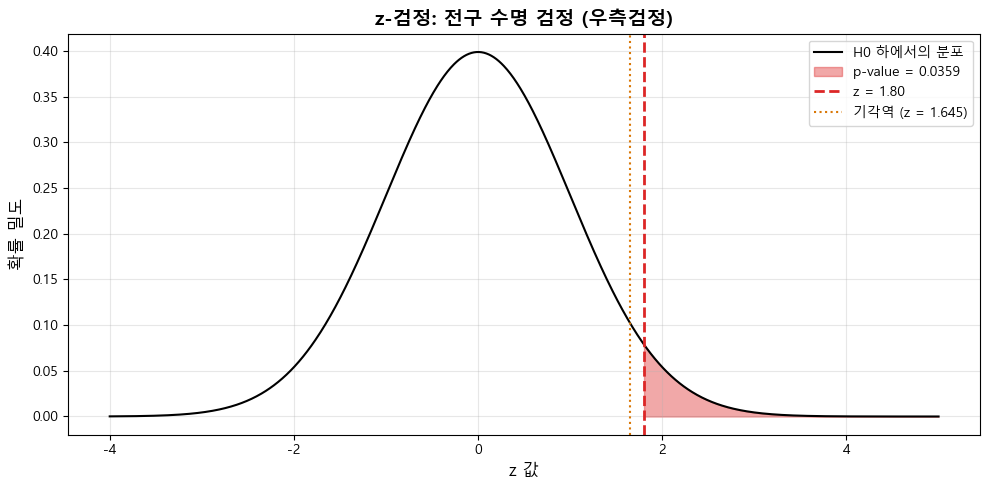

In [ ]:
# z-검정 실습 (수동 구현)
print("\n" + "=" * 60)
print("z-검정")
print("=" * 60)

print("\n[시나리오]")
print("전구 수명이 평균 1000시간이라고 알려져 있습니다. (σ = 50시간)")
print("새 공정으로 생산한 전구 36개의 평균 수명이 1015시간이었습니다.")
print("새 공정이 수명을 늘렸나요?")

mu_0 = 1000         # 귀무가설에서 주장하는 평균(기준값)
sigma = 50          # 알고 있다고 가정한 모표준편차(이게 z-검정의 핵심 전제)
n = 36              # 표본 크기
xbar = 1015         # 표본평균

print(f"\nH0: μ = {mu_0}")  #귀무가설 : 모집단의 평균이 1000시간 (현상유지)
print(f"H1: μ > {mu_0} (우측검정)") #귀무가설 : 모집단의 평균이 1000시간 이상이다

# TODO: z 검정통계량 계산 (xbar - mu_0) / (sigma / sqrt(n))
z_stats = (xbar - mu_0)  / (sigma / np.sqrt(n))
# 표본평균이 기준 μ0에서 표준오차 단위로 몇 칸 떨어졌는지 계산한다.

# TODO: p-value 계산 (우측검정: stats.norm.sf(z_stat))
# 좌측이면 CDF, 양측이면 2*sf(abs(z)
p_value = stats.norm.sf(z_stats)

# TODO: 결과 출력 및 판정 (α = 0.05)
a = 0.05
if p_value < a :
    print(f"{p_value}, 귀무가설 기각") # 95%신뢰 수준 - 새로운 공정은 1000시간 이상이다
else :
    print(f"{p_value}, 귀무가설 기각 실패")

# 시각화: z-검정 결과
z_stat = (xbar - mu_0) / (sigma / np.sqrt(n))
p_value = stats.norm.sf(z_stat)

fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(-4, 5, 1000)
y = stats.norm.pdf(x)

ax.plot(x, y, 'k-', linewidth=1.5, label='H0 하에서의 분포')
ax.fill_between(x[x >= z_stat], y[x >= z_stat], alpha=0.4, color='#DC2626',
                label=f'p-value = {p_value:.4f}')
ax.axvline(z_stat, color='#DC2626', linestyle='--', linewidth=2,
           label=f'z = {z_stat:.2f}')
ax.axvline(1.645, color='#D97706', linestyle=':', linewidth=1.5,
           label=f'기각역 (z = 1.645)')

ax.set_title('z-검정: 전구 수명 검정 (우측검정)', fontsize=14, fontweight='bold')
ax.set_xlabel('z 값', fontsize=12)
ax.set_ylabel('확률 밀도', fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 3. t-검정 (t-test)
모표준편차 σ를 모르기에 표본표준편차 s로 대신하고,\
그 불확실성을 반영해 t분포를 쓰는 평균 검정이다.

σ 대신 s를 쓰면 표준오차 추정이 흔들린다. 그래서 극단값 가능성을 더 크게 보는(꼬리가 두꺼운) t분포를 쓴다.\
표본이 커질수록 t분포는 정규분포에 가까워진다.

| 특징                     | 설명                                                   |
|--------------------------|--------------------------------------------------------|
| 정규분포와 비슷          | 종 모양, 좌우 대칭                                     |
| 꼬리가 더 두꺼움         | 정규분포보다 극단값이 나올 확률이 높음 → 더 보수적      |
| 자유도(df)에 따라 변화   | df가 커질수록 정규분포에 가까워짐                       |
| df = n - 1 (단일표본)    | 표본크기에서 1을 빼서 자유도 결정                      |

### 4. 단일표본 t-검정 (One-sample t-test)
한 집단의 표본평균이 기준값(μ0)과 다른지(또는 크고/작은지) t로 판단한다.\
표본평균이 기준값에서 얼마나 떨어졌는지(표준오차 단위로) 본다.

$t = \frac{\bar{X} - \mu_0}{s / \sqrt{n}}, \quad df = n - 1$

예시\
제품 평균 중량이 500g과 다른가?\
한 반 평균 점수가 전국 평균 70점과 다른가?

### 코드로 보자
- stats.ttest_1samp(sample, popmean=mu0, alternative = two-sided)
    - sample: 한 집단 데이터(리스트/배열)
    - popmean: 비교할 기준값 μ0(귀무가설의 평균)
    - alternative: (양측: two-sided) (좌측 단측: less ) (우측 단측: greater)

- statistic: t 통계량
- pvalue: 기본은 양측 p-value


In [30]:
print("\n" + "=" * 60)
print("Part 5.2.1: 단일표본 t-검정")
print("=" * 60)

print("\n[시나리오1] A 지역 성인 혈압 검정")
print("=" * 50)
print("A 지역은 건강 프로그램을 운영 중입니다.")
print("이 지역 성인 20명의 수축기 혈압을 측정하여")
print("전국 평균(130mmHg)보다 낮은지 검정합니다.")

np.random.seed(123)
bp_data = np.random.normal(loc=122, scale=12, size=20)

print(f"\n데이터: {np.round(bp_data, 1)}")
print(f"표본평균: {np.mean(bp_data):.2f} mmHg")
print(f"표준편차: {np.std(bp_data, ddof=1):.2f} mmHg")

print("\n[1단계] 가설 설정")
print("  H0: μ = 130  (전국 평균과 같다)")
print("  H1: μ < 130  (전국 평균보다 낮다) → 좌측검정")

alpha = 0.05
print(f"\n[2단계] 유의수준: α = {alpha}")

# ── 단일표본 t-검정 (one-sample t-test) ──
# 검정통계량: t = (x̄ - μ₀) / (s / √n)

# TODO: 표본크기 n, 귀무가설 모평균 mu_0 설정
n = len(bp_data)
mu_0 = 130

# TODO: 표본평균 x̄, 표본표준편차 s(ddof=1), 표준오차 SE 계산
xbar = np.mean(bp_data)
s = np.std(bp_data, ddof=1)
se = s / np.sqrt(n)

# TODO: 검정통계량 t 계산
t_stat = (xbar - mu_0) / se

# TODO: 자유도 df = n - 1
df = n - 1

# TODO: p-value 계산
p_value = stats.t.cdf(t_stat, df)

# TODO: 결과 출력
print(p_value) #0.032
# TODO: p-value와 α 비교하여 결론 출력
# a = 0.05 인 경우 귀무가설 기각

# ── scipy.stats로 검증 ──
# TODO: stats.ttest_1samp(bp_data, popmean=130) 으로 검증
#   주의: ttest_1samp은 양측 p-value를 반환합니다
#   좌측 변환: p_좌측 = p_양측/2 (t < 0일 때)
# TODO: 수동 계산 결과와 비교 출력
t_stat, p_value = stats.ttest_1samp(bp_data, popmean=130) # 양측 검정 p_value가 나옴
print(t_stat, p_value/2) #-1.964075748428177 0.06432176933739024


Part 5.2.1: 단일표본 t-검정

[시나리오1] A 지역 성인 혈압 검정
A 지역은 건강 프로그램을 운영 중입니다.
이 지역 성인 20명의 수축기 혈압을 측정하여
전국 평균(130mmHg)보다 낮은지 검정합니다.

데이터: [109.  134.  125.4 103.9 115.1 141.8  92.9 116.9 137.2 111.6 113.9 120.9
 139.9 114.3 116.7 116.8 148.5 148.2 134.  126.6]
표본평균: 123.37 mmHg
표준편차: 15.09 mmHg

[1단계] 가설 설정
  H0: μ = 130  (전국 평균과 같다)
  H1: μ < 130  (전국 평균보다 낮다) → 좌측검정

[2단계] 유의수준: α = 0.05
0.03216088466869513
-1.964075748428177 0.03216088466869512


In [31]:
print("\n[시나리오2] 커피 용량 품질 관리")
print("자판기 커피의 목표 용량: 200ml")
print("15잔을 측정했을 때, 규격에 맞는지 검정합니다")

np.random.seed(42)
coffee_ml = np.random.normal(loc=197, scale=5, size=15)

print(f"\n측정값: {np.round(coffee_ml, 1)}")
print(f"표본평균: {np.mean(coffee_ml):.2f}ml")
print(f"표본표준편차: {np.std(coffee_ml, ddof=1):.2f}ml")

# 가설
mu_0 = 200
print(f"\nH0: μ = {mu_0}ml (규격에 맞음)")
print(f"H1: μ ≠ {mu_0}ml (규격에 안 맞음) → 양측검정")

# TODO: scipy.stats로 단일표본 t-검정 (stats.ttest_1samp)
t_stat, p_value = stats.ttest_1samp(coffee_ml, popmean=200) 

# TODO: 결과 출력 (t-통계량, 자유도, p-value)
# TODO: p-value와 α 비교하여 결론 출력
print(t_stat, p_value) # -2.2971353602418363 0.0375536706473834 , 귀무가설을 기각!

# TODO: H0 기각 시 95% 신뢰구간도 계산하여 출력
ci = stats.t.interval(0.95, df=len(coffee_ml)-1, loc=np.mean(coffee_ml), scale=stats.sem(coffee_ml))
print(ci) #(np.float64(194.29901708052174), np.float64(199.80446816281156))


[시나리오2] 커피 용량 품질 관리
자판기 커피의 목표 용량: 200ml
15잔을 측정했을 때, 규격에 맞는지 검정합니다

측정값: [199.5 196.3 200.2 204.6 195.8 195.8 204.9 200.8 194.7 199.7 194.7 194.7
 198.2 187.4 188.4]
표본평균: 197.05ml
표본표준편차: 4.97ml

H0: μ = 200ml (규격에 맞음)
H1: μ ≠ 200ml (규격에 안 맞음) → 양측검정
-2.2971353602418363 0.0375536706473834
(np.float64(194.29901708052174), np.float64(199.80446816281156))


### 4. 독립표본 t-검정 (Independent two-sample t-test)
서로 다른 두 집단의 평균이 다른지 비교하는 평균 검정이다.\

A집단과 B집단이 서로 다른 사람/대상으로 구성되어 있을 때 평균 차이를 본다.\
실무에서는 두 집단 분산이 다를 수 있어서 Welch 방식이 자주 쓰인다.

$t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}, \quad df \approx \text{Welch 보정}$

예시\
A반 vs B반 시험 점수 평균 차이\
남성 vs 여성 평균 급여 차이\
실험군 vs 대조군 평균 효과 차이(서로 다른 참가자)\

### 코드로 보기
- stats.ttest_ind(group1, group2, alternative= ...,equal_var=...)
    - alternative: (양측: two-sided) (좌측 단측: less ) (우측 단측: greater)
    - equal_var: 
        - True: 등분산(두 집단 분산이 같다고 가정) Student t-test
        - False: 등분산 가정 안 함 Welch t-test (보통 이걸 기본으로 둔다)

- statistic: t 통계량
- pvalue: 기본은 양측 p-value


[시나리오] 두 학습법의 효과 비교
A법(전통 강의)과 B법(플립 러닝)으로 각각 수업 후 시험 점수 비교

A법 (전통 강의): n=25, 평균=70.36, SD=9.57
B법 (플립 러닝): n=30, 평균=75.49, SD=10.79


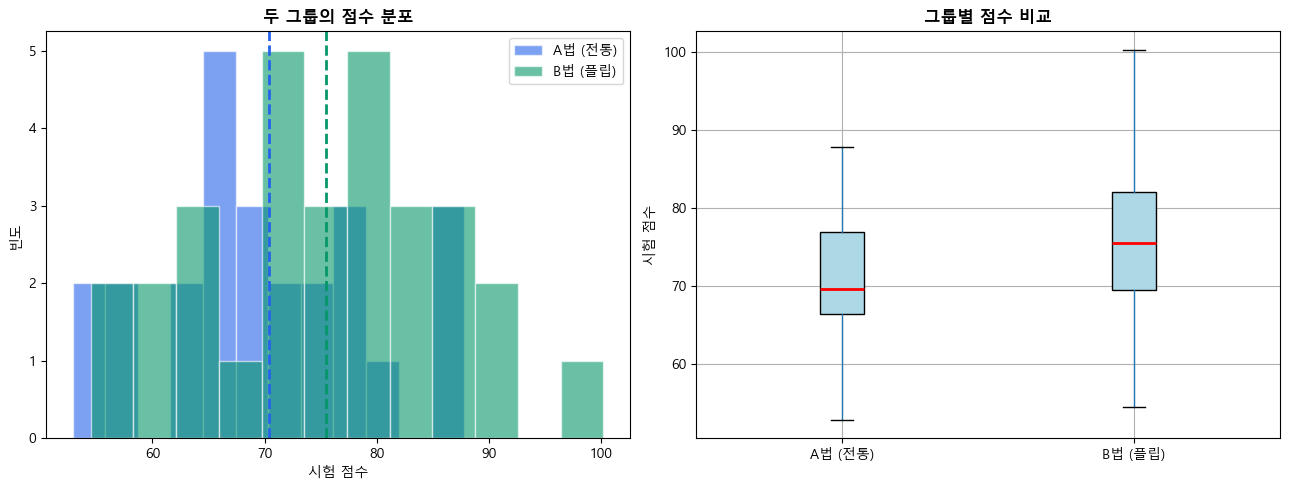

In [32]:
print("\n[시나리오] 두 학습법의 효과 비교")
print("A법(전통 강의)과 B법(플립 러닝)으로 각각 수업 후 시험 점수 비교")

np.random.seed(42)
group_a = np.random.normal(loc=72, scale=10, size=25)   # A법
group_b = np.random.normal(loc=78, scale=12, size=30)   # B법

print(f"\nA법 (전통 강의): n={len(group_a)}, 평균={np.mean(group_a):.2f}, "
      f"SD={np.std(group_a, ddof=1):.2f}")
print(f"B법 (플립 러닝): n={len(group_b)}, 평균={np.mean(group_b):.2f}, "
      f"SD={np.std(group_b, ddof=1):.2f}")

# 시각화: 두 그룹 비교
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# 히스토그램 비교
axes[0].hist(group_a, bins=12, alpha=0.6, color='#2563EB', edgecolor='white', label='A법 (전통)')
axes[0].hist(group_b, bins=12, alpha=0.6, color='#059669', edgecolor='white', label='B법 (플립)')
axes[0].axvline(np.mean(group_a), color='#2563EB', linestyle='--', linewidth=2)
axes[0].axvline(np.mean(group_b), color='#059669', linestyle='--', linewidth=2)
axes[0].set_xlabel('시험 점수')
axes[0].set_ylabel('빈도')
axes[0].set_title('두 그룹의 점수 분포', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)

# 박스플롯
data_box = pd.DataFrame({'A법 (전통)': pd.Series(group_a), 'B법 (플립)': pd.Series(group_b)})
data_box.boxplot(ax=axes[1], patch_artist=True,
                 boxprops=dict(facecolor='lightblue'),
                 medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('시험 점수')
axes[1].set_title('그룹별 점수 비교', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 가설
print(f"\nH0: μA = μB (두 학습법의 효과가 같다)")
print(f"H1: μA ≠ μB (두 학습법의 효과가 다르다)")


# 독립표본 t검정
# 1) 두 집단의 분산이 동일할 떄 : student's t검정
# 2) 두 집단의 분산이 다를 떄 :  Welch's t-test검정
# 일반적으로 다르고, 같다하더라도 Welch's t-test검정으로 해도 큰 차이가 없음! 
# 현대 통계학에서는 무조건 Welch's t-test검정을 한다!

# TODO: Welch's t-test 수행 
t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=False) 
#equal_var: 두그룹의 분산이 같은이 유무

# 유의수준 a = 0.05
print(p_value) #0.0677 
#--> 결과 : 귀무가설 기각 실패


H0: μA = μB (두 학습법의 효과가 같다)
H1: μA ≠ μB (두 학습법의 효과가 다르다)
0.06772897961019297


In [34]:
# ── 등분산 검정 ── 
# H0: 두 그룹의 분산이 같다 (등분산)
# H1: 두 그룹의 분산이 다르다 (이분산)
# p-value가 크다 → H0을 기각하지 못한다 → "분산이 같다"를 유지 → 등분산
# - Levene 검정: 정규성 가정이 필요 없음 (더 안전, 일반적으로 권장)
# - Bartlett 검정: 정규성을 가정함 (데이터가 정규분포일 때 더 정확)

lev_stat, lev_p = stats.levene(group_a, group_b)
bar_stat, bar_p = stats.bartlett(group_a, group_b)

print("[등분산 검정]")
print(f"  Levene:   F = {lev_stat:.4f}, p-value = {lev_p:.4f}")
print(f"  Bartlett: χ² = {bar_stat:.4f}, p-value = {bar_p:.4f}")

# H0: 두 그룹의 분산이 같다
# p > 0.05 → 등분산 가정 가능 → equal_var=True (Student's t-test)
# p ≤ 0.05 → 등분산 가정 불가 → equal_var=False (Welch's t-test)

if lev_p > 0.05:
    print("  → 등분산 가정 가능 (Student's t-test)")
else:
    print("  → 등분산 가정 불가 (Welch's t-test 사용)")

[등분산 검정]
  Levene:   F = 0.6378, p-value = 0.4281
  Bartlett: χ² = 0.3723, p-value = 0.5418
  → 등분산 가정 가능 (Student's t-test)


### 5. 대응표본 t-검정 (Paired t-test)
같은 대상의 전/후(또는 짝이 있는 두 측정)에서 **변화량의 평균**이 0인지(또는 한쪽 방향인지)를 검정한다.

핵심은 두 번의 측정값 자체가 아니라, 각 사람의 차이 di를 만든 뒤 그 차이의 평균이 0인지 보는 것이다.

$t = \frac{\bar{d}}{s_d / \sqrt{n}}, \quad \text{여기서 } d_i = X_{after,i} - X_{before,i}$


예시\
다이어트 전후 체중 변화
교육 전후 점수 변화
약 복용 전후 혈압 변화

#### 독립표본 vs 대응표본 구분법(초간단)
같은 사람 전후면 **대응**, 서로 다른 사람이면 **독립**\
대응은 짝이 있어 개인차를 상쇄하기 쉬워 더 예민하게 변화 감지가 가능하다.(조건이 맞으면)

예시\
같은 30명 전/후 → 대응표본\
전반 30명, 후반 30명(사람 다름) → 독립표본

### 코드로보기
- stats.ttest_rel(after, before, alternative=...)
    - alternative: (양측: two-sided) (좌측(감소 검정): less ) (우측(증가 검정): greater)

- statistic: t 통계량(변화량 평균이 0에서 얼마나 떨어졌는지)
- pvalue: 기본은 양측 p-value

In [35]:
print("\n" + "=" * 60)
print("Part 5.2.3: 대응표본 t-검정")
print("=" * 60)

print("\n[시나리오] 다이어트 프로그램 효과 검증")
print("12명이 8주간 다이어트 프로그램에 참여")
print("프로그램 전후 체중(kg)을 비교")

# 데이터 표본
np.random.seed(42)
n_people = 12
before = np.random.normal(loc=80, scale=8, size=n_people)
weight_loss = np.random.normal(loc=2, scale=3, size=n_people)
after = before - weight_loss

print(f"\n{'대상':>6} {'전(kg)':>10} {'후(kg)':>10} {'차이(kg)':>10}")
print("-" * 40)
for i in range(n_people):
    diff = after[i] - before[i]
    print(f"  {i+1:>3d}   {before[i]:>8.1f}   {after[i]:>8.1f}   {diff:>8.1f}")

differences = after - before
print(f"\n차이(d = 후 - 전)의 평균: {np.mean(differences):.2f} kg")
print(f"차이의 표준편차: {np.std(differences, ddof=1):.2f} kg")

# 가설
print(f"\nH0: μd = 0 (프로그램 효과 없음)")
print(f"H1: μd < 0 (프로그램으로 체중 감소) → 좌측검정")

# TODO: 대응표본 t-검정
t_stat, p_value =  stats.ttest_rel(after, before) 

# 좌측 단측 검정 ->  체중이 감소한 경우 t 값이 음수가 나옴

print(t_stat, p_value) # -0.2613935364835901 0.7986185686922294

p_value  = p_value / 2 if t_stat < 0 else  1 - p_value / 2 # 양측검정의 p값을 2로 나눠서 단측 검정의 p값으로 한다

alpha = 0.05
if  t_stat < 0  and p_value <= alpha :
    print(f'P_{p_value} H0 귀무가설 기각 : 다이어트 프로그램이 효과가 있다고 말 할 수 있다.')
else :
    print(f'P_{p_value} H0 귀무가설 지지 : 다이어트 프로그램이 효과가 없다고 말 할 수 있다.')
    


Part 5.2.3: 대응표본 t-검정

[시나리오] 다이어트 프로그램 효과 검증
12명이 8주간 다이어트 프로그램에 참여
프로그램 전후 체중(kg)을 비교

    대상      전(kg)      후(kg)     차이(kg)
----------------------------------------
    1       84.0       81.2       -2.7
    2       78.9       82.6        3.7
    3       85.2       88.4        3.2
    4       92.2       91.9       -0.3
    5       78.1       79.2        1.0
    6       78.1       75.2       -2.9
    7       92.6       93.4        0.7
    8       86.1       88.4        2.2
    9       76.2       69.8       -6.4
   10       84.3       83.0       -1.3
   11       76.3       74.1       -2.2
   12       76.3       78.5        2.3

차이(d = 후 - 전)의 평균: -0.23 kg
차이의 표준편차: 3.00 kg

H0: μd = 0 (프로그램 효과 없음)
H1: μd < 0 (프로그램으로 체중 감소) → 좌측검정
-0.2613935364835901 0.7986185686922294
P_0.3993092843461147 H0 귀무가설 지지 : 다이어트 프로그램이 효과가 없다고 말 할 수 있다.


| 조건                      | 검정 방법            | scipy.stats 함수                    |
|---------------------------|----------------------|-------------------------------------|
| 모분산 σ를 아는 경우 (안씀)     | **z-검정**           | `statsmodels.stats.weightstats`     |
| 1개 표본, σ 모름          | **단일표본 t-검정**  | `stats.ttest_1samp(data, mu0)`      |
| 2개 독립 표본, σ 모름     | **독립표본 t-검정**  | `stats.ttest_ind(a, b)`             |
| 2개 짝지은(전후) 표본     | **대응표본 t-검정**  | `stats.ttest_rel(before, after)`    |

<img src="images/pr_03/검정_선택_가이드.png" width="75%">

---

## Part 6: 오류와 검정력

### 1. 가설검정의 오류
| 오류 유형           | 정의            | 확률 | 핵심 키워드             |
| --------------- | ------------- | -: | ------------------ |
| 1종 오류 (Type I)  | H0가 참인데 기각    |  α | 거짓 양성(없는데 있다고 함)   |
| 2종 오류 (Type II) | H1이 참인데 기각 실패 |  β | 거짓 음성(있는데 없다고 넘어감) |


#### 1종 오류 (Type I Error, α) (거짓 양성)
H0가 실제로 참인데도, 우연히 극단적인 표본이 나와 H0를 기각해버리는 오류\
없던 효과를 "있다"라 결론 내리는 실수다.

예시\
실제로 신약 효과가 없는데, 표본에서 큰 차이가 나와 p=0.03이 뜨고 α=0.05라서 H0를 기각해버리는 경우.

#### 2종 오류 (Type II Error, β) (거짓 음성)
H1이 실제로 참인데도, 표본이 작거나 변동이 커서 H0를 기각하지 못하는 오류다.\
있던 효과를 "없다/모르겠다/로 놓치는 실수다.

예시\
실제로 신약이 효과가 있는데도 표본이 너무 적어 p=0.12가 나오고, 그래서 H0를 기각 못해서 효과를 놓치는 경우.


#### α와 β의 Trade-off(서로 반대 방향)
기각 기준을 더 엄격하게(α↓) 하면 거짓 양성은 줄지만, 효과를 놓칠 가능성(β↑)이 커질 수 있다.

해석\
α를 낮추면 "정말 확실할 때 기각"\
그래서 1종 오류는 줄어들지만, 실제 효과가 있어도 증거가 부족하다고 판단해 넘어가는 일(거짓 양성)이 늘 수 있다.

β를 낮추면 "조금만 증거가 있어도 기각"쪽으로 간다.\
그래서 실제 효과를 놓칠 확률은 줄어들지만, 효과가 없는데도 있다고 판단하는 경우(거짓 양성)가 늘 수 있다.

### 2. 효과크기 (Effect Size)
해당 효과가 **얼마나 크냐**를 말한다.

p-value는 표본이 크면 작은 차이도 유의해질 수 있고, 표본이 작으면 큰 차이도 유의하지 않을 수 있다.\
그래서 실제 의미 있는 차이인지 보려면 효과크기를 함께 본다.

예시\
표본 10,000명: 평균 차이 0.5점 → p는 매우 작을 수 있지만 실제로는 별 의미 없을 수 있음\
표본 20명: 평균 차이 15점 → p는 0.08이라 유의하지 않아도 실제 차이는 클 수 있음(표본이 작아 검정력이 부족)

#### Cohen’s d (대표적인 효과크기)
평균 차이가 **표준편차 몇 개(몇 배)인지로 효과 크기를 재는 값**

단위(점수, cm 등)를 없애고 표준편차 기준으로 비교하니 해석이 쉬워진다.\
d≈0.2 작음, 0.5 중간, 0.8 큼(관례)

| 검정 유형 | 공식 |
|----------|------|
| 단일표본 | $d = \frac{\bar{X} - \mu_0}{s}$ |
| 독립표본 | $d = \frac{\bar{X}_1 - \bar{X}_2}{s_{pooled}}$ |
| 대응표본 | $d = \frac{\bar{X}_{diff}}{s_{diff}}$ |
> 공식은 굳이...

> **참고**: 이 기준은 Cohen(1988)이 제안한 관례적 수치로 절대적인 수치가 아니다.\ 
분야에 따라 기준이 다를 수 있다.

- 

In [ ]:
# ── Cohen's d 함수 정의 (검정 유형별) ──

def cohens_d_one(data, mu_0): # 단일표본 d
    """Cohen's d — 단일표본: d = |x̄ - μ₀| / s"""
    return abs(np.mean(data) - mu_0) / np.std(data, ddof=1)

def cohens_d_ind(group1, group2): # 독립표본 d(합동표준편차 사용)
    """Cohen's d — 독립표본: d = |x̄₁ - x̄₂| / s_pooled"""
    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)) # 합동 분산 
    return abs(np.mean(group1) - np.mean(group2)) / s_pooled

def cohens_d_paired(before, after): # 대응표본 d(차이값 diff 기준)
    """Cohen's d — 대응표본: d = |x̄_diff| / s_diff"""
    diff = after - before
    return abs(np.mean(diff)) / np.std(diff, ddof=1)

def interpret_d(d): # 해석
    """Cohen's d 해석"""
    if d < 0.2:
        return "무시할 수준"
    elif d < 0.5:
        return "작은 효과"
    elif d < 0.8:
        return "중간 효과"
    else:
        return "큰 효과"

In [ ]:
# 효과크기 계산 실습
print("\n[실습] 효과크기 (Cohen's d)")
print("=" * 50)

alpha = 0.05

# ── 1. 단일표본 예시: A 지역 혈압 데이터 ──
print("\n[1] 단일표본 (A 지역 혈압)")
print("-" * 40)
print("  H0: μ = 130 (전국 평균과 같다)")
print("  H1: μ < 130 (전국 평균보다 낮다) → 좌측검정")

np.random.seed(123)
bp_data = np.random.normal(loc=122, scale=12, size=20)

# TODO: 단일표본 t-검정 수행 (stats.ttest_1samp, popmean=130)
t_stat, p_value = stats.ttest_1samp(bp_data, popmean=130)

# TODO: 좌측 p-value 변환
p_value = p_value /2 if t_stat < 0 else 1 -  p_value /2 

# TODO: Cohen's d 계산 (cohens_d_one)
d_one = cohens_d_one(bp_data, 130)

# TODO: 결과 출력 (t, p-value, Cohen's d, 해석)
print(t_stat, p_value, d_one)
print(interpret_d(d_one))

# -1.964075748428177 0.03216088466869512 0.43918068864441795
# 작은 효과

# 해석
# --> A지역의 혈압은 전국 평균보다 낮다 (큰 차이는 없다)


# ── 2. 독립표본 예시: 두 학습법 ──
print(f"\n[2] 독립표본 (학습법 비교)")
print("-" * 40)
print("  H0: μA = μB (두 학습법의 효과가 같다)")
print("  H1: μA < μB (B법이 더 효과적이다) → 좌측검정")

np.random.seed(42)
group_a = np.random.normal(loc=72, scale=10, size=25)
group_b = np.random.normal(loc=78, scale=12, size=30)

# TODO: 독립표본 t-검정 수행 (stats.ttest_ind, equal_var=False)
# TODO: 좌측 p-value 변환
# TODO: Cohen's d 계산 (cohens_d_ind)
# TODO: 결과 출력 (t, p-value, Cohen's d, 해석)

t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=False)
# stats.ttest_1samp(bp_data, popmean= 130, alternative= "less")  # alternative: less 좌측 단측검정, greater 우측 단측검정
# alternative 디폴트 = two-sided

# TODO: 좌측 p-value 변환
p_value = p_value /2 if t_stat < 0 else 1 -  p_value /2 

# TODO: Cohen's d 계산 (cohens_d_one)
d_one = cohens_d_ind(group_a, group_b)

# TODO: 결과 출력 (t, p-value, Cohen's d, 해석)
print(t_stat, p_value, d_one)
print(interpret_d(d_one))

# -1.8651151939368984 0.03386448980509649 0.4994841219130416
# 작은 효과

# 해석
# --> B의 학습법이 효과적이나 (큰 차이는 없다)

# ── 3. 대응표본 예시: 다이어트 전후 ──
print(f"\n[3] 대응표본 (다이어트 전후)")
print("-" * 40)
print("  H0: μ_diff = 0 (체중 변화 없음)")
print("  H1: μ_diff < 0 (체중이 감소함) → 좌측검정")

np.random.seed(99)
weight_before = np.random.normal(loc=75, scale=8, size=15)
weight_after = weight_before + np.random.normal(loc=-3, scale=2, size=15)

# TODO: 대응표본 t-검정 수행 (stats.ttest_rel)
# TODO: 좌측 p-value 변환
# TODO: Cohen's d 계산 (cohens_d_paired)
# TODO: 결과 출력 (전/후 평균, 변화량, t, p-value, Cohen's d, 해석)


t_stat_3, p_one_3 = stats.ttest_rel(weight_after, weight_before, alternative='less') #후, 전 <--
d_paired = cohens_d_paired(weight_before, weight_after)

print(f"  전 평균: {np.mean(weight_before):.2f}kg → 후 평균: {np.mean(weight_after):.2f}kg")
print(f"  평균 변화: {np.mean(weight_after - weight_before):.2f}kg")
print(f"  t = {t_stat_3:.4f}, p-value (좌측) = {p_one_3:.4f}") 
print(f"  Cohen's d = {d_paired:.4f} → {interpret_d(d_paired)}")

# H0: μ_diff = 0 (체중 변화 없음)
#   H1: μ_diff < 0 (체중이 감소함) → 좌측검정
#   전 평균: 76.96kg → 후 평균: 73.53kg
#   평균 변화: -3.43kg
#   t = -9.8507, p-value (좌측) = 0.0000
#   Cohen's d = 2.5434 → 큰 효과

# p-value큰데 효과크기가 큰 경우 어떻게 해석??
# 대립가설을 지지하고 효과크기도 크니 다이어트가 굉장히 효과적이다!!




# --> p_value > 0.05 and 효과크기가 중간 이상!

# 대립가설을 지지할 증거가 부족하다고 결론을 내리는게 합리적 --> 효과크기가 크니까
# 표본이 15

# 그 다음에 어떻게?? --> 표본을 늘려본다. 
# 실험 설계를 다시 해서 표본을 늘린다.


# 다시 설계하면 저희가 원하는 결과를 일부러 만드는 것으로 생각해볼 수도 있다고 생각해서 그렇습니다.
# --> 표본을 내가 원하는 결과의 표본만 추출하는 문제 생김!!!
# --> 다시 실험을 공정하게 한다면 --> 결과가 당연히 동일하거나 비슷하게 나와야함
# --> 표본이 너무 작은것도 사실 --> 30이상, 실험을 하는 것이 합리적

# 10000 표본이 큰데 --> 효과크기도 작은데
# --> 다시한 번 실험설계 


[실습] 효과크기 (Cohen's d)

[1] 단일표본 (A 지역 혈압)
----------------------------------------
  H0: μ = 130 (전국 평균과 같다)
  H1: μ < 130 (전국 평균보다 낮다) → 좌측검정
-1.964075748428177 0.03216088466869512 0.43918068864441795
작은 효과

[2] 독립표본 (학습법 비교)
----------------------------------------
  H0: μA = μB (두 학습법의 효과가 같다)
  H1: μA < μB (B법이 더 효과적이다) → 좌측검정
-1.8651151939368984 0.03386448980509649 0.4994841219130416
작은 효과

[3] 대응표본 (다이어트 전후)
----------------------------------------
  H0: μ_diff = 0 (체중 변화 없음)
  H1: μ_diff < 0 (체중이 감소함) → 좌측검정
  전 평균: 76.96kg → 후 평균: 73.53kg
  평균 변화: -3.43kg
  t = -9.8507, p-value (좌측) = 0.0000
  Cohen's d = 2.5434 → 큰 효과


### 3. 검정력 (Power = 1 − β)
검정력은 실제로 효과가 있을 때(H1이 참일 때) 그 효과를 잡아내서 H0를 기각할 확률\
β(2종 오류): 효과가 있음에도 못 잡고 넘어갈 확률\
검정력은 "효과를 놓치지 않는 정도"라 보면 된다.

| 검정력 수준 | 평가                                         |
|-------------|----------------------------------------------|
| 0.80 (80%)  | 최소 권장 수준 (Cohen, 1988)                  |
| 0.90 (90%)  | 양호                                         |
| 0.95 (95%)  | 매우 좋음                                    |

> 검정력이 0.8이면, 실제 효과가 있을 때 비슷한 실험을 많이 반복하면 약 80%는 유의하다고 결론(기각) 내릴 수 있다는 뜻이다.

#### 검정력에 영향을 주는 요인
| 요인                 | 검정력에 미치는 영향                                |
|----------------------|----------------------------------------------------|
| **표본크기 n ↑**     | 검정력 ↑ (가장 직접적이고 효과적인 방법)             |
| **효과크기 ↑**       | 검정력 ↑ (실제 차이가 클수록 탐지 쉬움)              |
| **유의수준 α ↑**     | 검정력 ↑ (하지만 1종 오류도 증가)                    |
| **분산 σ² ↓**        | 검정력 ↑ (데이터가 깔끔할수록 탐지 쉬움)<>             |

### 코드로 보자

- statsmodels.stats.power.TTestPower() 
```
analysis = TTestPower()
power_lib = TTestPower.solve_power(
        effect_size=    # 효과 크기,
        nobs =          # 표본 크기
        alpha =         # 유의 수준
        alternative =   # 신뢰구간 설정
    )
```

In [38]:
# 검정력 분석 실습
print("\n" + "=" * 60)
print("검정력 분석")
print("=" * 60)

print("\n[시나리오] 신약 혈압 강하 효과")
print("귀무가설: μ = 0 (효과 없음)")
print("대립가설: μ = -5 (혈압 5mmHg 강하)")
print("σ = 15, α = 0.05, 단측검정")

mu_0 = 0
mu_1 = -5
sigma = 15
alpha = 0.05

# ─────────────────────────────────────────────
# 수동 계산: 표본크기별 검정력
# ─────────────────────────────────────────────
print("\n[표본크기별 검정력] (수동 계산)")
print("-" * 45)
print(f"{'n':>6} {'SE':>10} {'검정력':>10} {'평가':>10}")
print("-" * 45)

for n in [10, 20, 30, 50, 100, 200]:
    se = sigma / np.sqrt(n)
    df = n - 1

    # TODO: 기각역 계산 (좌측검정, t-분포: stats.t.ppf(alpha, df))
    t_crit = stats.t.ppf(alpha, df=df)
    
    # TODO: 기각 임계값 x_crit = mu_0 + t_crit * se
    x_crit = mu_0 + t_crit * se # 표본 평균의 기각 임계값
    
    # TODO: 검정력 계산: H1 하에서 기각역에 들어갈 확률
    power = stats.t.cdf(x_crit, df=df, loc=mu_1, scale=se)
    
    
    # TODO: 결과 출력
    print(n, se, power)


검정력 분석

[시나리오] 신약 혈압 강하 효과
귀무가설: μ = 0 (효과 없음)
대립가설: μ = -5 (혈압 5mmHg 강하)
σ = 15, α = 0.05, 단측검정

[표본크기별 검정력] (수동 계산)
---------------------------------------------
     n         SE        검정력         평가
---------------------------------------------
10 4.743416490252569 0.22798092434988596
20 3.3541019662496843 0.40705362228174036
30 2.7386127875258306 0.5499404668052478
50 2.1213203435596424 0.7502956636642895
100 1.5 0.9512520133576181
200 1.0606601717798212 0.998746753083792


In [39]:
# ─────────────────────────────────────────────
# 라이브러리 검증: statsmodels TTestPower
# ─────────────────────────────────────────────
from statsmodels.stats.power import TTestPower

analysis = TTestPower()

# TODO: Cohen's d 계산 (|mu_1 - mu_0| / sigma)
d = abs(mu_1 - mu_0) / sigma #효과 크기


# TODO: 표본크기별 수동 vs 라이브러리 검정력 비교
for n in [10, 20, 30, 50, 100, 200]:
    se = sigma / np.sqrt(n)
    df = n - 1

    # TODO: 기각역 계산 (좌측검정, t-분포: stats.t.ppf(alpha, df))
    t_crit = stats.t.ppf(alpha, df=df)
    
    # TODO: 기각 임계값 x_crit = mu_0 + t_crit * se
    x_crit = mu_0 + t_crit * se # 표본 평균의 기각 임계값
    
    # TODO: 검정력 계산: H1 하에서 기각역에 들어갈 확률
    power = stats.t.cdf(x_crit, df=df, loc=mu_1, scale=se)
    
    # 일반 t분포로 계산하지 않음, 
    # 비중심 t-분포로 검정력을 더 정확히 계산
    power_lib = analysis.solve_power( #공식문서 참고
        effect_size=d, #효과 크기,
        nobs = n, # 표본 크기
        alpha = alpha, #유의 수준
        alternative = 'larger' #단측검정
    )
    # solve_power 함수 특징이 3개의 인자를 주면 나머지 하나를 역산 
    # 4개중에 3개를 입력하면 나머지 하나를 역산 effect_size, nobs, alpha, power
    
    
    # statsmodels의 alternative 옵션은 effect_size의 부호 기준으로 방향을 잡는다.
    # d = +0.333 + alternative='larger' → 효과가 양의 방향으로 있다고 검정 → 검정력 계산 O
    # d = -0.333 + alternative='smaller' → 효과가 음의 방향으로 있다고 검정 → 같은 결과
    # 두 가지 방법 모두 같은 검정력이 나옵니다.
    # 검정력 계산에서는 좌측, 우측 단측이 방향만 맞으면 결과가 같기 때문에, 관례적으로 d를 양수로 넣고 'larger'를 쓰는 경우가 많습니다.
    

    # TODO: 결과 출력
    print(f"{power:.2f}, {power_lib:.2f}")

0.23, 0.25
0.41, 0.42
0.55, 0.55
0.75, 0.75
0.95, 0.95
1.00, 1.00


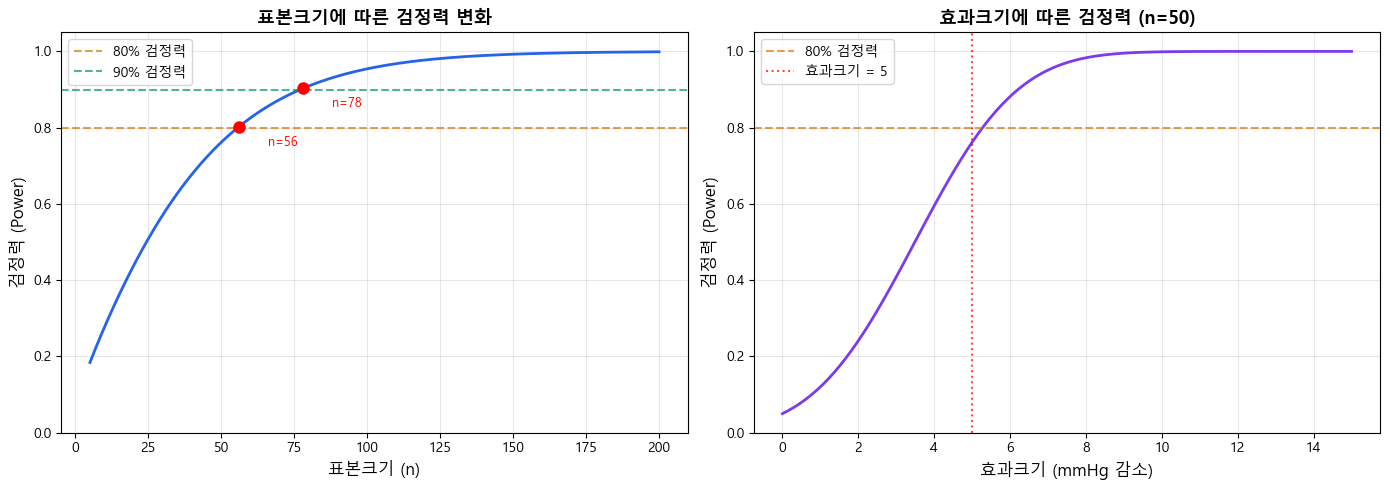

In [40]:
# 시각화: 검정력 곡선
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) 표본크기 vs 검정력
n_range = np.arange(5, 201)
powers = []
for n in n_range:
    se = sigma / np.sqrt(n)
    z_crit = stats.norm.ppf(alpha)
    x_crit = mu_0 + z_crit * se
    power = stats.norm.cdf(x_crit, loc=mu_1, scale=se)
    powers.append(power)

axes[0].plot(n_range, powers, color='#2563EB', linewidth=2)
axes[0].axhline(0.80, color='#D97706', linestyle='--', alpha=0.7, label='80% 검정력')
axes[0].axhline(0.90, color='#059669', linestyle='--', alpha=0.7, label='90% 검정력')

for target_power in [0.80, 0.90]:
    for n in n_range:
        se = sigma / np.sqrt(n)
        z_crit = stats.norm.ppf(alpha)
        x_crit = mu_0 + z_crit * se
        p = stats.norm.cdf(x_crit, loc=mu_1, scale=se)
        if p >= target_power:
            axes[0].plot(n, p, 'o', markersize=8, color='red')
            axes[0].annotate(f'n={n}', xy=(n, p), xytext=(n+10, p-0.05),
                             fontsize=9, color='red')
            break

axes[0].set_xlabel('표본크기 (n)', fontsize=12)
axes[0].set_ylabel('검정력 (Power)', fontsize=12)
axes[0].set_title('표본크기에 따른 검정력 변화', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_ylim(0, 1.05)

# (2) 효과크기 vs 검정력 (n=50 고정)
n_fixed = 50
effect_sizes = np.linspace(0, 15, 100)
powers_effect = []
for eff in effect_sizes:
    se = sigma / np.sqrt(n_fixed)
    z_crit = stats.norm.ppf(alpha)
    x_crit = mu_0 + z_crit * se
    power = stats.norm.cdf(x_crit, loc=mu_0 - eff, scale=se)
    powers_effect.append(power)

axes[1].plot(effect_sizes, powers_effect, color='#7C3AED', linewidth=2)
axes[1].axhline(0.80, color='#D97706', linestyle='--', alpha=0.7, label='80% 검정력')
axes[1].axvline(5, color='red', linestyle=':', alpha=0.7, label='효과크기 = 5')
axes[1].set_xlabel('효과크기 (mmHg 감소)', fontsize=12)
axes[1].set_ylabel('검정력 (Power)', fontsize=12)
axes[1].set_title(f'효과크기에 따른 검정력 (n={n_fixed})', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [41]:
# ── solve_power 역산 기능: 4개 중 3개를 주면 나머지 1개를 구해줍니다 ──
print("\n[실습] solve_power 역산 기능")
print("=" * 60)
print("TTestPower.solve_power는 4개 인자 중 1개를 None으로 두면")
print("나머지 3개로부터 해당 값을 역산해줍니다.")
print("  → effect_size, nobs, alpha, power 중 하나를 구할 수 있습니다.")

from statsmodels.stats.power import TTestPower

analysis = TTestPower()
d = abs(mu_1 - mu_0) / sigma
print(f"Cohen's d ={d}")

# ─────────────────────────────────────────────
# (1) 검정에 필요한 표본크기 역산: "80% 검정력을 달성하려면 n이 몇 명 필요한가?" #가설 설계 중요
# ─────────────────────────────────────────────
print(f"\n[1] 필요 표본크기 역산 (가장 많이 쓰는 기능)")
print("-" * 50)

for target_power in [0.80, 0.90, 0.95]:
    # TODO: 결과 출력
    
    n_req = analysis.solve_power( #공식문서 참고
        effect_size=d, #효과 크기,
        alpha = alpha, #유의 수준
        power = target_power,
        alternative = 'larger' #단측검정
    )
    
    print(target_power, np.ceil(n_req))
  

# ─────────────────────────────────────────────
# (2) 검정력 계산: "n=50일 때 검정력은?"
# ─────────────────────────────────────────────
print(f"\n[2] 검정력 계산")
print("-" * 50)
# TODO: 결과 출력
power = analysis.solve_power( #공식문서 참고
    effect_size=d, #효과 크기,
    alpha = alpha, #유의 수준
    nobs = 50,
    alternative = 'larger' #단측검정
) 
print(power) #0.75


# ─────────────────────────────────────────────
# (3) 탐지 가능한 최소 효과크기: "n=50, power=0.8 으로 탐지할 수 있는 최소 효과는?"
# ─────────────────────────────────────────────
print(f"\n[3] 탐지 가능한 최소 효과크기 역산")
print("-" * 50)
# TODO: 결과 출력

d_min = analysis.solve_power( #공식문서 참고
    alpha = alpha, #유의 수준
    nobs = 50,
    power = 0.8,
    alternative = 'larger' #단측검정
) 
print(d_min) # 0.35



# ─────────────────────────────────────────────
# (4) 실전 활용: 연구 설계 시 표본크기 결정
# ─────────────────────────────────────────────
print(f"\n[4] 실전 활용: 효과크기별 필요 표본크기 비교")
print("-" * 55)
print(f"  '혈압 몇 mmHg 차이를 탐지하고 싶은가?'에 따라 필요 n이 달라집니다")
print(f"  (검정력 80%, α = 0.05, σ = {sigma} 기준)")
print(f"{'효과(mmHg)':>12} {'Cohen d':>10} {'필요 n':>10} {'효과 해석':>12}")
print("-" * 55)

for effect_mmhg in [2, 3, 5, 8, 10]:
    # TODO: Cohen's d 계산 
    d = effect_mmhg / sigma # 대응표본에서의 효과크기
    
    # TODO: solve_power로 필요 n 역산
    n_req = analysis.solve_power( #공식문서 참고
        effect_size=d, #효과 크기,
        alpha = alpha, #유의 수준
        power = 0.8,
        alternative = 'larger' #단측검정
    )
    
    # TODO: 결과 출력
    print(effect_mmhg, np.ceil(n_req))


[실습] solve_power 역산 기능
TTestPower.solve_power는 4개 인자 중 1개를 None으로 두면
나머지 3개로부터 해당 값을 역산해줍니다.
  → effect_size, nobs, alpha, power 중 하나를 구할 수 있습니다.
Cohen's d =0.3333333333333333

[1] 필요 표본크기 역산 (가장 많이 쓰는 기능)
--------------------------------------------------
0.8 58.0
0.9 79.0
0.95 99.0

[2] 검정력 계산
--------------------------------------------------
0.7515644412622811

[3] 탐지 가능한 최소 효과크기 역산
--------------------------------------------------
0.3565996544505667

[4] 실전 활용: 효과크기별 필요 표본크기 비교
-------------------------------------------------------
  '혈압 몇 mmHg 차이를 탐지하고 싶은가?'에 따라 필요 n이 달라집니다
  (검정력 80%, α = 0.05, σ = 15 기준)
    효과(mmHg)    Cohen d       필요 n        효과 해석
-------------------------------------------------------
2 350.0
3 156.0
5 58.0
8 24.0
10 16.0
